In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from sklearn.linear_model import LinearRegression
from scipy.stats import f_oneway
import numpy as np, statsmodels.api as sm
from scipy.stats import kruskal
import scikit_posthocs as sp
from IPython.display import display, Markdown, clear_output
import ipywidgets as widgets
from ipywidgets.embed import embed_minimal_html
from ipywidgets import interactive, VBox
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tools.sm_exceptions import ValueWarning as SMValueWarning
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings


# deal with warnings

In [2]:
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", SMValueWarning)
warnings.simplefilter("ignore", ConvergenceWarning)  # ARIMA warnings


# constant

In [3]:

tashlomim_path = 'mimun.csv'
hazmanot_path = 'order.csv'

# only sog hotza 10,20,45
EXPECTED_BI_COLUMNS = [
    'budget_year', 'order_id', 'fingroup', 'po_2', 'coin', 'huka',
    'expediture_type', 'fc4', 'fund_code', 'zroa', 'doc_type',
    'paymant_date', 'expected_payment_date','sales_office',
    'sales_document_type', 'sales_group', 'inviting_partner',
    'order_starting_date', 'number_of_rows', 'sales_organistion',
    'sales_order_sum','order_line_balance', 'mimun'
]
# only seif 15
# only sog hotza 10,20,45
# only coin 1 and 5
EXPECTED_TASHLOMIM_COLUMNS = [
    'budget_year', 'order_id', 'order_line', 'fingroup', 'po_2', 'coin',
    'huka', 'expediture_type', 'fc4', 'fund_code', 'zroa', 'doc_type',
     'fc3', 'paymant_date', 'mimun'
]

EXPECTED_HAZMANOT_COLUMNS = ['order_id', 'order_line', 'po_2', 'fund_code', 'sales_office',
       'sales_organistion', 'sales_document_type', 'sales_group',
       'inviting_partner', 'order_starting_date', 'fc', 'sales_order_sum',
       'order_line_balance']

TODAY_YEAR = 2025
YEAR_TO_PREDICT = 2026
OLD_BUDGET_YEAR_TO_REMOVE = 2007
COIN_TO_INSPECT = 1
PO_2_TO_REMOVE = [59851024]
SALES_DOCUMENT_TO_REMOVE = ["ZG2G"]
ALL_YEARS_IN_DATA = list(range(2008, TODAY_YEAR + 1))
R2_THRESHOLD_FOR_REGRESSION = 0.5
ELASTICITY_THRESHOLD_FOR_REGRESSION = 0.1
ZERO_RATIO_THRESHOLD = 0.9
ACTUAL_LAST_MONTH_IN_DATA = 11
ARIMA_ORDER = (0, 2, 0)
ROLLING_WINDOW = 12
DEVIATION_THRESHOLD = 3
MIN_POINTS = ROLLING_WINDOW // 2
MONTHS_IN_YEAR = 12
CONFIDENCE_Z = 0.95  # 95% confidence interval
TREND_SELECTED = 'c'  # centered moving average
MIN_POINTS_FOR_FORECASTING = 12

TREND_VS_ROLLING_STD_ANALYSIS = """
## Trend vs Rolling Standard Deviation Analysis

This analysis examines whether the **variability of the series changes with its level**.

If the variance **increases as the trend increases**, this indicates a **multiplicative structure** rather than an additive one.

### What we examine:

- **Trend**: estimated using a centered moving average to capture long-term level changes.
- **Rolling standard deviation**: measures local variability around the trend.
- **Key diagnostic**: whether variability scales with the trend level.

### Interpretation:

- If rolling standard deviation **increases with the trend**, fluctuations scale with the level  
  → suggests **multiplicative decomposition**
- If rolling standard deviation is **roughly constant**, variability is independent of level  
  → suggests **additive decomposition**
"""
TREND_VS_ROLLING_STD_REGRESSION = r"""
### Trend vs Rolling Std – Formal Regression Test

To quantify whether variability grows with the trend, we fit a **linear regression** between the rolling standard deviation and the trend.

$$
\text{rolling\_std} = \alpha + \beta \cdot \text{trend} + \epsilon
$$

### Interpretation of parameters:

- $\alpha$ (intercept): baseline variability when the trend is near zero  
- $\beta$ (slope): rate at which variability changes as the trend increases  
- $\epsilon$: unexplained noise

### Decision logic:

- $\beta > 0$ and meaningful fit → variability increases with level → **multiplicative pattern**
- $\beta \approx 0$ → variability independent of level → **additive pattern**
"""
### elasticity = slope * np.mean(trend) / np.mean(rolling_std)
### means proportional change in volatility relative to proportional change in trend (scale free)

TIME_SERIES_DECOMPOSITION = """
## Time Series Decomposition

We decompose the observed time series \( y_{t} \) into three components:

$$
y_{t} = T_{t} + S_{t} + R_{t}
$$

### Components:

- **Trend** \( T_{t} \): long-term movement, estimated via centered moving average  
- **Seasonality** \( S_{t} \): systematic, calendar-related effects  
- **Residuals** \( R_{t} \): irregular noise and unexplained variation

### Intermediate step:

- **Detrended series**:  
  \[
  y_{t} - T_{t} = S_{t} + R_{t}
  \]

Seasonality is estimated by averaging the detrended values across the same seasonal period.
"""
MONTHLY_SEASONALITY_ANALYSIS = r"""
## Monthly Seasonality – Distribution Shape

Boxplots are used to compare **monthly distributions** and inspect skewness.

### Rule of thumb:

- **Right-skewed distribution** → mean **above** median  
- **Left-skewed distribution** → mean **below** median

This helps interpret whether extreme values systematically pull the average up or down for specific months.
"""
MONTHLY_SEASONALITY_TEST = r"""
## Monthly Seasonality – Kruskal–Wallis Test

We use the **Kruskal–Wallis test** to determine whether **monthly observations come from the same distribution**.

This non-parametric test is appropriate when data is skewed or contains many zeros.

### Hypotheses:

- **Null hypothesis** \( H_0 \): all months follow the same distribution  
- **Alternative hypothesis** \( H_1 \): at least one month differs

### Interpretation:

- \( p < 0.05 \) → reject \( H_0 \) → evidence of monthly seasonality  
- \( p \ge 0.05 \) → fail to reject \( H_0 \) → no strong evidence of differences
"""
SARMIA_START = " SARIMA SUMMERY"

<>:93: SyntaxWarning: invalid escape sequence '\('
<>:93: SyntaxWarning: invalid escape sequence '\('
/var/folders/sq/n201c_056g59wrkbqkwrq7k40000gn/T/ipykernel_8243/3939923189.py:93: SyntaxWarning: invalid escape sequence '\('
  We decompose the observed time series \( y_{t} \) into three components:


# checking the data 

In [4]:
def read_csv_safely(path, **kwargs):
    try:
        return pd.read_csv(path, **kwargs)  # UTF-8 (default)
    except UnicodeError:  # broader & correct
        return pd.read_csv(path, encoding="cp1252", **kwargs)


def load_tashlomim_and_hazmanot(path, type):
    df = read_csv_safely(path)  

    # Clean column names FIRST
    df.columns = (df.columns
                    .str.strip()
                    .str.lower()
                    .str.replace('-', '_')
                    .str.replace(' ', '_'))

    # Select expected schema and remove weird columns
    if type == "tashlomim":
        df.columns = EXPECTED_TASHLOMIM_COLUMNS

    elif type == "hazmanot":
        df.columns = EXPECTED_HAZMANOT_COLUMNS
        df = df[df["fund_code"] != "#"]

    else:
        raise ValueError(f"Unknown type '{type}'")

    # Apply dtypes
    if type == "tashlomim":
        df = df.astype({
            "order_id": "string",
            "po_2": "Int64",
            "coin": "Int64",
            "budget_year": "Int64"
        }, errors="raise")

    if type == "hazmanot":
        df = df.astype({
            "order_id": "string",
            "fund_code": "string",
            "order_starting_date": "Int64"
        }, errors="raise")

    return df
tashlomim_data_orginal_from_user = load_tashlomim_and_hazmanot(tashlomim_path, "tashlomim")
hazmanot_data_original_from_user = load_tashlomim_and_hazmanot(hazmanot_path, "hazmanot")

# orders in tashlumim that are not in hazmanot

In [5]:
set_order_id_in_tashlumim = set(tashlomim_data_orginal_from_user["order_id"].tolist())
set_order_id_in_hazmanot = set(hazmanot_data_original_from_user["order_id"].tolist())
order_ids_not_in_hazmanot = set_order_id_in_tashlumim - set_order_id_in_hazmanot
#print(order_ids_not_in_hazmanot)


remove orders that in hazmanot and not in tashlumim

# make the data at the format i need

In [6]:
# make copy before preprocess the data
hazmanot_data_original = hazmanot_data_original_from_user.copy()
tashlomim_data_orginal = tashlomim_data_orginal_from_user.copy()

# add proper date to tashlomim data
tashlomim_data_orginal["paymant_date"] = pd.to_datetime(
    tashlomim_data_orginal["paymant_date"], 
    unit="D", 
    origin="1899-12-30"
)
# add payment year to tashlomim data
tashlomim_data_orginal["payment_year"] = tashlomim_data_orginal["paymant_date"].dt.year
tashlomim_data_orginal["payment_month"] = tashlomim_data_orginal["paymant_date"].dt.month

# add proper date to hazmanot data
hazmanot_data_original["order_starting_date"] = pd.to_datetime(
    hazmanot_data_original["order_starting_date"], 
    unit="D", 
    origin="1899-12-30"
)
# add order starting year to hazmanot data
hazmanot_data_original["starting_year"] = hazmanot_data_original["order_starting_date"].dt.year

# if mimun is NaN convert it to 0 and remove it
tashlomim_data_orginal["mimun"] = tashlomim_data_orginal["mimun"].fillna(0)
tashlomim_data_orginal = tashlomim_data_orginal[tashlomim_data_orginal["mimun"] != 0]

#first 4 chars of fund code are budget year and make it int
hazmanot_data_original["budget_year"] = hazmanot_data_original["fund_code"].str[:4]
hazmanot_data_original["budget_year"] = hazmanot_data_original["budget_year"].astype(int)

#filter out old budget years 
tashlomim_data_orginal = tashlomim_data_orginal[tashlomim_data_orginal["budget_year"] > OLD_BUDGET_YEAR_TO_REMOVE]
hazmanot_data_original = hazmanot_data_original[hazmanot_data_original["budget_year"] > OLD_BUDGET_YEAR_TO_REMOVE]

# make mimun positive 
tashlomim_data_orginal["mimun"] = tashlomim_data_orginal["mimun"] * -1


# orders id that has po 2 "55546078" and po 2 that has diff po 2 as well

In [7]:
order_id_that_po_2_to_remove = hazmanot_data_original[hazmanot_data_original["po_2"] == "55546078"]["order_id"].unique()
data_that_orders_have_Po_2_to_remove_and_other_po_2 = hazmanot_data_original[hazmanot_data_original["order_id"].isin(order_id_that_po_2_to_remove) & (hazmanot_data_original["po_2"] != "55546078")]
#print(data_that_orders_have_Po_2_to_remove_and_other_po_2)

# okay so now i will remove zg2g and 59851024

In [8]:
# find hazmanot that are from sales document SALES_DOCUMENT_TO_REMOVE
set_sales_document_remove_in_hazmanot = hazmanot_data_original[(hazmanot_data_original["sales_document_type"].isin(SALES_DOCUMENT_TO_REMOVE))]["order_id"].unique()

# remove set_sales_document_remove_in_hazmanot from hazmanot and tashlomim data but make sure not on smah order (#) stays in data
#tashlomim_data_orginal = tashlomim_data_orginal[~(tashlomim_data_orginal["order_id"].isin(set_sales_document_remove_in_hazmanot))]
#hazmanot_data_original = hazmanot_data_original[~(hazmanot_data_original["sales_document_type"].isin(SALES_DOCUMENT_TO_REMOVE))]

# find hazmanot that are under po_2 of PO_2_TO_REMOVE
set_po_2_remove_in_tashlomim = tashlomim_data_orginal[tashlomim_data_orginal["po_2"].isin(PO_2_TO_REMOVE)]["order_id"].unique()

# remove set_po_2_remove_in_tashlomim from hazmanot and tashlomim data
tashlomim_data_orginal = tashlomim_data_orginal[~(tashlomim_data_orginal["po_2"].isin(PO_2_TO_REMOVE))]

mask_remove_from_hazmanot = hazmanot_data_original["order_id"].isin(set_po_2_remove_in_tashlomim)
hazmanot_data_original = hazmanot_data_original[~(hazmanot_data_original["order_id"].isin(set_po_2_remove_in_tashlomim))]


# remove from coin 5 the orders that are from biden

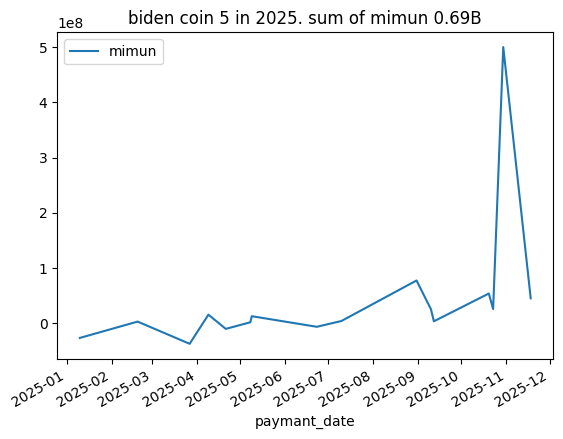

In [9]:

conditions = (
    (tashlomim_data_orginal["budget_year"] == 2025) &
    (tashlomim_data_orginal["coin"] == 5) &
    (tashlomim_data_orginal["huka"] == 5270) &
    (tashlomim_data_orginal["expediture_type"] == 10) &
    (tashlomim_data_orginal["zroa"] == 91) &
    (tashlomim_data_orginal["doc_type"] == "DR") &
    (tashlomim_data_orginal["po_2"] == 53041026) &
    (tashlomim_data_orginal["fingroup"] == "1153/17") &
    (tashlomim_data_orginal["fc4"] == 1153)
)
if conditions.sum() != 0:
    # plot the 
    time_series_biden_5 = tashlomim_data_orginal[conditions]
    sum = time_series_biden_5["mimun"].sum()
    time_series_biden_5.groupby(["paymant_date"]).agg({"mimun":"sum"}).plot(title= f"biden coin 5 in 2025. sum of mimun {sum / 1e9:.2f}B")
    # remove the biden row from the data
    tashlomim_data_orginal = tashlomim_data_orginal[(~tashlomim_data_orginal.index.isin(time_series_biden_5.tail(1).index))]

# start to inspect the data according to one type of coin

In [10]:
# find the coin in hazmanot date (it is the 5 number in fund_code)
hazmanot_data_original["coin"] = hazmanot_data_original["fund_code"].str[4]

# drop bad rows where coin is nan
hazmanot_data_orginal = hazmanot_data_original[hazmanot_data_original["coin"].notna()]

# make coin in hazmanot astype int
hazmanot_data_original["coin"] = pd.to_numeric(
    hazmanot_data_original["coin"],
    errors="raise"
)

# look at data specific coin
tashlomim_data_specific_coin = tashlomim_data_orginal[tashlomim_data_orginal["coin"] == COIN_TO_INSPECT]
hazmanot_data_specific_coin = hazmanot_data_original[hazmanot_data_original["coin"] == COIN_TO_INSPECT]


# expenditure type development by years 

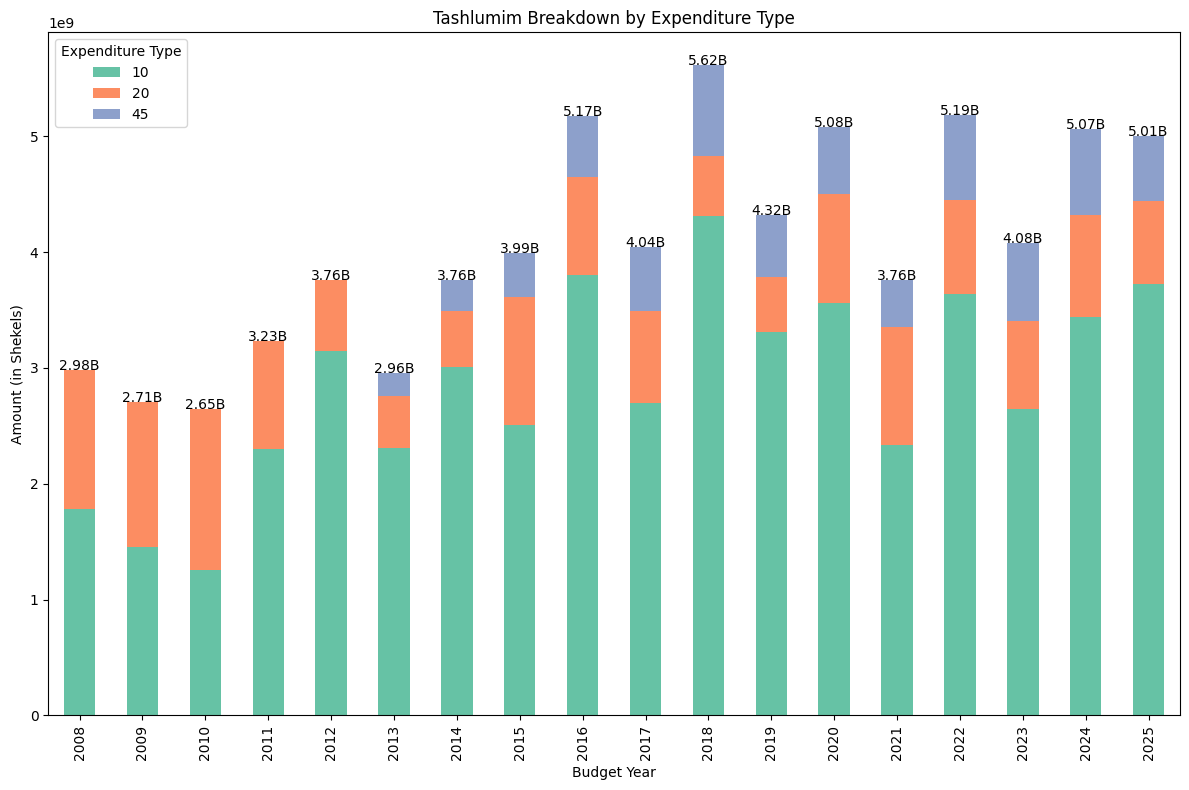

In [11]:
# group by expenditure type in tashlomim data
tashlomim_expenditure_type = tashlomim_data_specific_coin.groupby(["budget_year", "expediture_type"]).agg({'mimun':'sum'})

# pivot the data for better plotting
tashlomim_expenditure_type = tashlomim_expenditure_type.unstack("expediture_type")

# change column names
tashlomim_expenditure_type.columns = tashlomim_expenditure_type.columns.droplevel()

# plot the expenditure type and beautify the plot and sum labels on top of bars and legend better
colors = sns.color_palette("Set2", len(tashlomim_expenditure_type.columns))
tashlomim_expenditure_type.plot(kind='bar', stacked=True, figsize=(12,8), color=colors)
plt.title('Tashlumim Breakdown by Expenditure Type')
plt.xlabel('Budget Year')
plt.ylabel('Amount (in Shekels)')
for i in range(len(tashlomim_expenditure_type)):
    plt.text(i, tashlomim_expenditure_type.iloc[i].sum(), f"{tashlomim_expenditure_type.iloc[i].sum()/1e9:.2f}B", ha='center')
plt.legend(title='Expenditure Type')
plt.tight_layout()
plt.show()

# tashlomim breakdown over the years on smah and not on smah

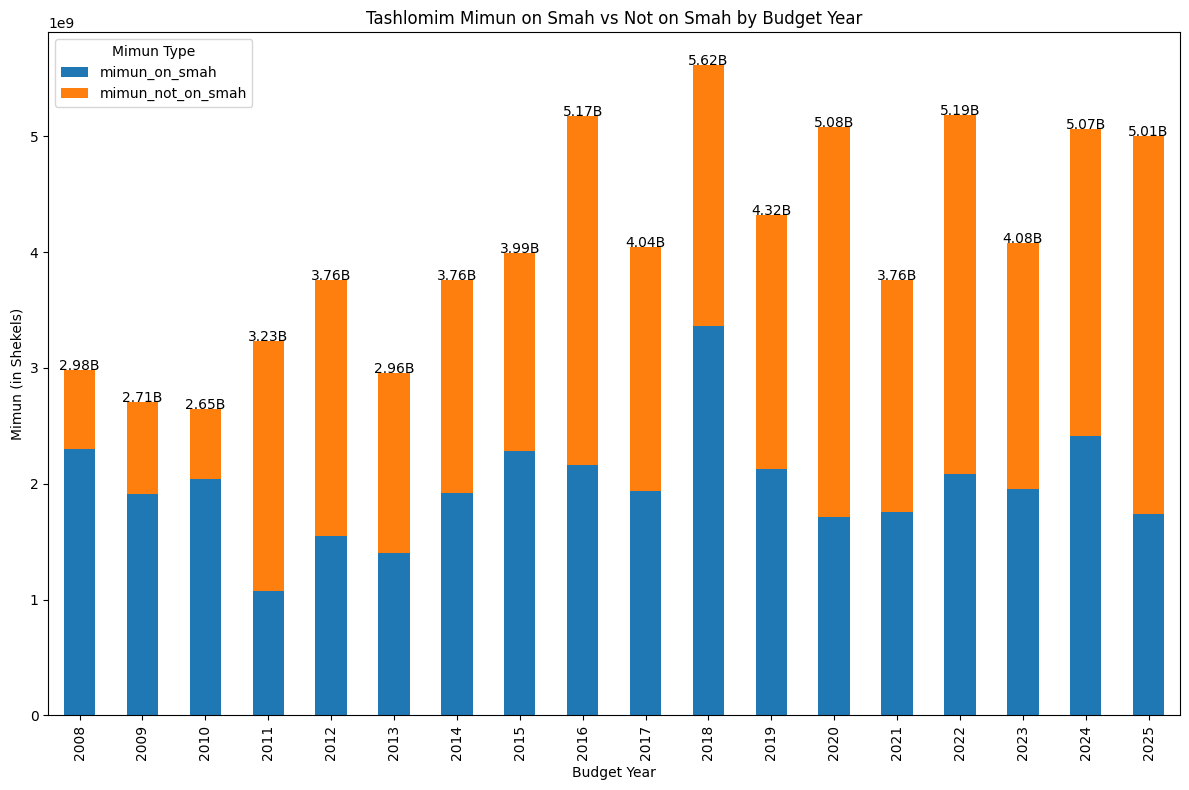

In [12]:
# insepcting specific data
group_tashlumim = tashlomim_data_specific_coin.groupby(["budget_year","order_id","zroa"]).agg({'mimun': 'sum'}).reset_index()

#organize data for plotting all
order_id_on_smah = group_tashlumim[group_tashlumim["order_id"] != "#"].groupby("budget_year").agg({'mimun': 'sum'})
order_id_not_on_smah = group_tashlumim[group_tashlumim["order_id"] == "#"].groupby("budget_year").agg({'mimun': 'sum'})
concat_order_id = pd.concat([order_id_on_smah, order_id_not_on_smah], axis=1)
concat_order_id.columns = ['mimun_on_smah', 'mimun_not_on_smah']
concat_order_id = concat_order_id.sort_index()

# plot on smah and not on smah mimun by budget year
concat_order_id.plot(kind='bar', stacked=True, figsize=(12,8))
plt.title('Tashlomim Mimun on Smah vs Not on Smah by Budget Year')
plt.xlabel('Budget Year')
plt.ylabel('Mimun (in Shekels)')
for i in range(len(concat_order_id)):
    plt.text(i, concat_order_id.iloc[i].sum(), f"{concat_order_id.iloc[i].sum()/1e9:.2f}B", ha='center')
plt.legend(title='Mimun Type')
plt.tight_layout()
plt.show()

# distribution of tashlomim mimun values

### x axis is signed_log_mimun=sign(mimun)×log(∣mimun∣), for example 13.8 on x-axis means order_id for 1e6 sum
### y axis is probability density, meaning:The total area under all bars ≈ 1. The height tells you how concentrated the data is in that region.
### somethign interesting is the data disterbution looks normal
### pointing out i ignored zero in the data for better plot

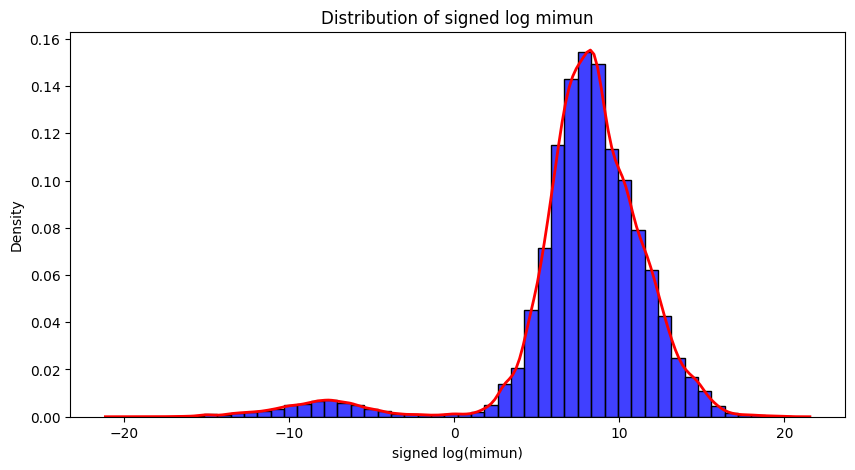

In [13]:
# distribution of tashlomim mimun values after log transformation with sign preserved
tashlomim_data_shekel_distribution = tashlomim_data_specific_coin.copy()
tashlomim_data_shekel_distribution['signed_log_mimun'] = np.sign(tashlomim_data_specific_coin['mimun']) * np.log(np.abs(tashlomim_data_specific_coin['mimun']))

# plot 
plt.figure(figsize=(10,5))

# Histogram bars in blue
sns.histplot(
    tashlomim_data_shekel_distribution['signed_log_mimun'], 
    bins=50, 
    color='blue', 
    stat='density', 
    kde=False  # turn off default KDE
)

# KDE line in red
sns.kdeplot(
    tashlomim_data_shekel_distribution['signed_log_mimun'], 
    color='red', 
    linewidth=2
)

plt.title("Distribution of signed log mimun")
plt.xlabel("signed log(mimun)")
plt.ylabel("Density")
plt.show()


# make zroa and fc3 widget

In [14]:
dropdown_zroa_fc3 = widgets.Dropdown(
    options=["fc3", "zroa"],
    value="fc3",
    description='Choose a feature to use:',
    disabled=False,
    style={'description_width': 'initial'}
)

# Variable to store current selection
selected_feature = {'value': dropdown_zroa_fc3.value}  # start with default

# Callback function
def update_dropdown_zroa_fc3(change):
    if change['name'] == 'value':  # make sure it's value change
        selected_feature['value'] = change['new']
        print(f"Selected feature: {selected_feature['value']}")

# Connect callback
dropdown_zroa_fc3.observe(update_dropdown_zroa_fc3)

# Display widget
display(dropdown_zroa_fc3)



Dropdown(description='Choose a feature to use:', options=('fc3', 'zroa'), style=DescriptionStyle(description_w…

In [15]:
fc_or_zroa_selected = selected_feature["value"]

# zroa and fc3 Analysis for 2025


IntSlider(value=5, continuous_update=False, description='Top N:', max=20, min=3, style=SliderStyle(description…

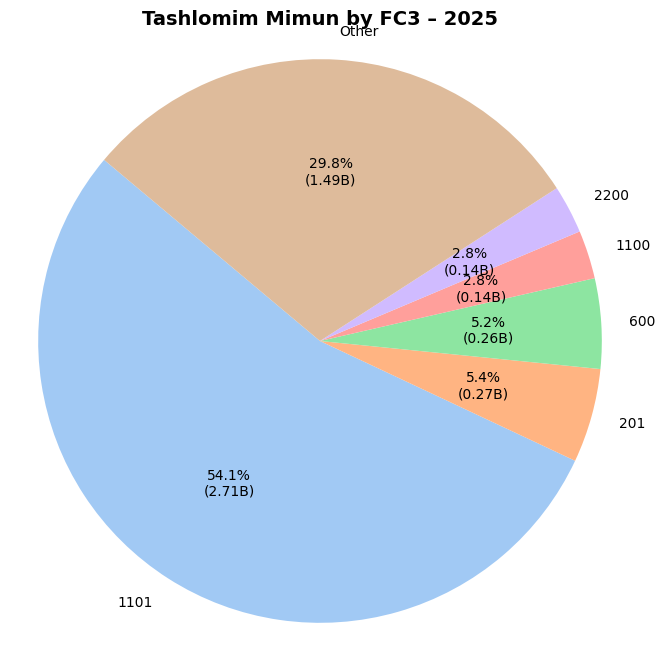

In [16]:
top_n_widget = widgets.IntSlider(
    value=5,
    min=3,
    max=20,
    step=1,
    description="Top N:",
    continuous_update=False,
    style={"description_width": "initial"}
)

display(top_n_widget)

def plot_tashlomim_pie(top_n):
    clear_output(wait=True)

    # IMPORTANT: re-display widget after clear_output
    display(top_n_widget)

    fc_or_zroa_selected = selected_feature["value"]
    specific_year = 2025

    df_year = tashlomim_data_specific_coin[
        tashlomim_data_specific_coin["budget_year"] == specific_year
    ]

    grouped = df_year.groupby(fc_or_zroa_selected).agg({"mimun": "sum"})

    sizes_full = grouped["mimun"].abs().sort_values(ascending=False)

    if len(sizes_full) > top_n:
        top = sizes_full.head(top_n)
        others_sum = sizes_full.iloc[top_n:].sum()
        sizes = pd.concat([top, pd.Series({"Other": others_sum})])
    else:
        sizes = sizes_full

    def make_autopct(total):
        def f(pct):
            val = pct * total / 100
            return f"{pct:.1f}%\n({val/1e9:.2f}B)"
        return f

    plt.figure(figsize=(8, 8))
    colors = sns.color_palette("pastel", len(sizes))

    plt.pie(
        sizes,
        labels=sizes.index,
        autopct=make_autopct(sizes.sum()),
        startangle=140,
        colors=colors
    )

    plt.title(
        f"Tashlomim Mimun by {fc_or_zroa_selected.upper()} – {specific_year}",
        fontsize=14,
        fontweight="bold"
    )
    plt.axis("equal")
    plt.show()
    
top_n_widget.observe(
    lambda change: plot_tashlomim_pie(change["new"]),
    names="value"
)

# initial plot
plot_tashlomim_pie(top_n_widget.value)


# check what fc4 there is under each zroa and what fc3 unfer each huka

Dropdown(description='Mode:', options=('fc4 in zroa', 'fc3 in huka'), style=DescriptionStyle(description_width…

Dropdown(description='Value:', options=(10, 20, 30, 40, 50, 60, 64, 70, 90, 91, 92, 93, 99), style=Description…

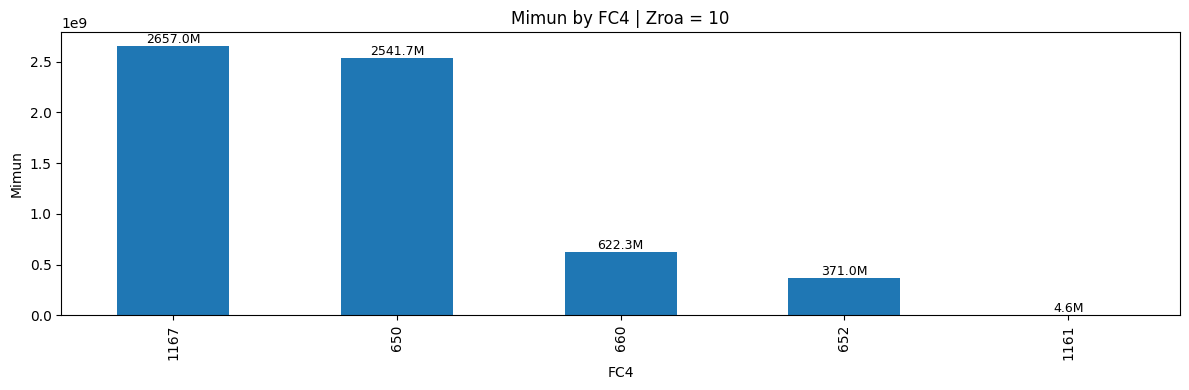

In [17]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

MIN_MIMUN = 1_000_000  # minimum mimun to show

# =====================================================
# Prepare data once
# =====================================================
df = (
    tashlomim_data_specific_coin
    .groupby(["zroa", "fc4", "huka", "fc3"], as_index=False)
    .agg({"mimun": "sum"})
)

# =====================================================
# Shared plotter class
# =====================================================
class FeaturePlotter:
    def __init__(self, df):
        self.df = df

    def plot(self, mode, parent_value):
        clear_output(wait=True)
        display(mode_dropdown, parent_dropdown)

        if mode == "fc4 in zroa":
            parent_col = "zroa"
            child_col = "fc4"
            title = f"Mimun by FC4 | Zroa = {parent_value}"
        else:  # fc3 in huka
            parent_col = "huka"
            child_col = "fc3"
            title = f"Mimun by FC3 | Huka = {parent_value}"

        # group and filter only positive, >= MIN_MIMUN
        plot_df = (
            self.df[self.df[parent_col] == parent_value]
            .groupby(child_col)["mimun"]
            .sum()
        )

        plot_df = plot_df[plot_df >= MIN_MIMUN].sort_values(ascending=False)

        if plot_df.empty:
            print(f"No {child_col.upper()} with mimun ≥ {MIN_MIMUN/1e6:.0f}M for {parent_value}")
            return

        ax = plot_df.plot(kind="bar", figsize=(12, 4), title=title)
        ax.set_xlabel(child_col.upper())
        ax.set_ylabel("Mimun")

        for i, v in enumerate(plot_df):
            ax.text(i, v, f"{v/1e6:.1f}M", ha="center", va="bottom", fontsize=9)

        plt.tight_layout()
        plt.show()


# =====================================================
# Widgets
# =====================================================
mode_dropdown = widgets.Dropdown(
    options=["fc4 in zroa", "fc3 in huka"],
    description="Mode:",
    style={"description_width": "initial"}
)

parent_dropdown = widgets.Dropdown(
    description="Value:",
    style={"description_width": "initial"}
)

plotter = FeaturePlotter(df)


# =====================================================
# Widget logic
# =====================================================
def update_parent_options(*args):
    """Update the dropdown with only parents that have total mimun >= MIN_MIMUN"""
    if mode_dropdown.value == "fc4 in zroa":
        # sum mimun per zroa
        sums = df.groupby("zroa")["mimun"].sum()
        parent_dropdown.options = sorted(sums[sums >= MIN_MIMUN].index.tolist())
    else:
        sums = df.groupby("huka")["mimun"].sum()
        parent_dropdown.options = sorted(sums[sums >= MIN_MIMUN].index.tolist())

    # select first value
    if parent_dropdown.options:
        parent_dropdown.value = parent_dropdown.options[0]
    else:
        parent_dropdown.value = None

def update_plot(change=None):
    if parent_dropdown.value is not None:
        plotter.plot(mode_dropdown.value, parent_dropdown.value)
    else:
        clear_output(wait=True)
        display(mode_dropdown, parent_dropdown)
        print(f"No parent with mimun ≥ {MIN_MIMUN/1e6:.0f}M to plot.")

# Attach observers
mode_dropdown.observe(update_parent_options, names="value")
parent_dropdown.observe(update_plot, names="value")

# =====================================================
# Initial render
# =====================================================
update_parent_options()
display(mode_dropdown, parent_dropdown)
update_plot()


# zroa analysis for tashlomim on smah and not on smah


Dropdown(description='Feature:', options=('fc3', 'zroa'), style=DescriptionStyle(description_width='initial'),…

Dropdown(description='Mode:', options=('SMAH vs Not on SMAH', 'Mimun vs Sales Order Sum'), style=DescriptionSt…

IntSlider(value=5, description='Top N:', max=20, min=1, style=SliderStyle(description_width='initial'))

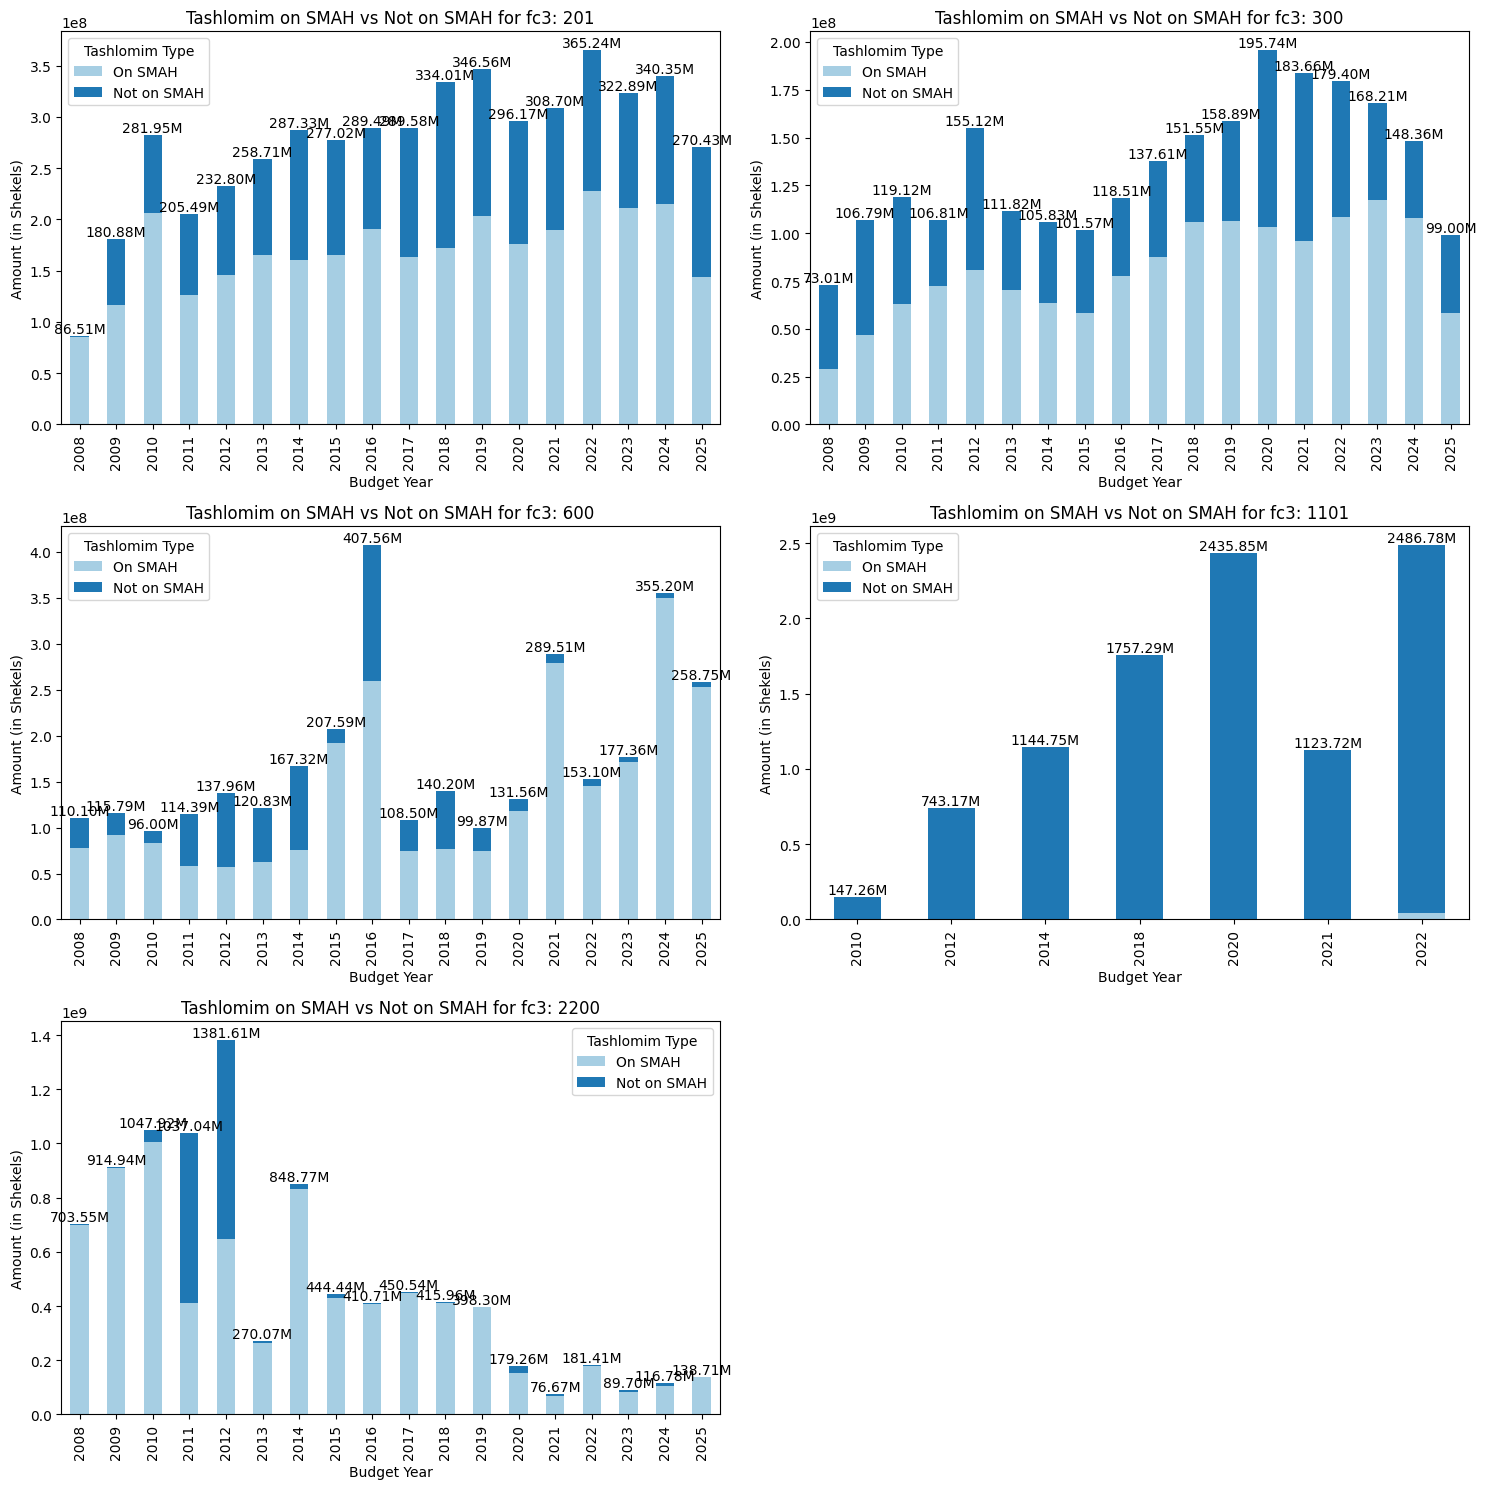

In [18]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math

# -----------------------------
# Widgets
# -----------------------------
feature_dropdown = widgets.Dropdown(
    options=["fc3", "zroa"],
    value="fc3",
    description="Feature:",
    style={"description_width": "initial"}
)

mode_dropdown = widgets.Dropdown(
    options=["SMAH vs Not on SMAH", "Mimun vs Sales Order Sum"],
    value="SMAH vs Not on SMAH",
    description="Mode:",
    style={"description_width": "initial"}
)

topn_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description="Top N:",
    style={"description_width": "initial"}
)

# -----------------------------
# Plot function
# -----------------------------
def plot_graph(feature, mode, top_n):
    clear_output(wait=True)
    display(feature_dropdown, mode_dropdown, topn_slider)
    
    if mode == "SMAH vs Not on SMAH":
        # ----------------------------
        # Prepare data
        # ----------------------------
        on_smah = tashlomim_data_specific_coin[tashlomim_data_specific_coin["order_id"] != "#"]
        not_on_smah = tashlomim_data_specific_coin[tashlomim_data_specific_coin["order_id"] == "#"]

        on_smah_grouped = on_smah.groupby(["budget_year", feature]).agg({"mimun":"sum"})
        not_on_smah_grouped = not_on_smah.groupby(["budget_year", feature]).agg({"mimun":"sum"})

        merged = pd.merge(
            on_smah_grouped, 
            not_on_smah_grouped,
            on=["budget_year", feature],
            suffixes=("_on_smah", "_not_on_smah")
        ).reset_index()

        merged = merged.groupby([feature, "budget_year"]).sum()
        merged["total_mimun"] = merged[["mimun_on_smah","mimun_not_on_smah"]].sum(axis=1)
        merged_filtered = merged[merged["total_mimun"] > 1e6]  # filter small values

        # Take Top N
        top_features = merged_filtered.groupby(level=0)["total_mimun"].sum().sort_values(ascending=False).head(top_n).index
        top_data = merged_filtered.loc[merged_filtered.index.get_level_values(0).isin(top_features)]

        # ----------------------------
        # Plot
        # ----------------------------
        colors = sns.color_palette("Paired", 2)
        size = top_data.index.get_level_values(0).nunique()
        fig, axes = plt.subplots(math.ceil(size/2), 2, figsize=(15, size*3))
        axes = axes.flatten()

        for i, (val, group) in enumerate(top_data.groupby(level=0)):
            ax = axes[i]
            plot_df = group[["mimun_on_smah", "mimun_not_on_smah"]].copy()
            plot_df.index = plot_df.index.get_level_values(1)  # budget_year as x-axis

            plot_df.plot(kind="bar", stacked=True, ax=ax, color=colors)

            ax.set_title(f"Tashlomim on SMAH vs Not on SMAH for {feature}: {val}")
            ax.set_xlabel("Budget Year")
            ax.set_ylabel("Amount (in Shekels)")
            ax.legend(title="Tashlomim Type", labels=["On SMAH", "Not on SMAH"])

            for j in range(len(plot_df)):
                total = plot_df.iloc[j].sum()
                ax.text(j, total, f"{total/1e6:.2f}M", ha="center", va="bottom")

        for k in range(i+1, len(axes)):
            fig.delaxes(axes[k])

        plt.tight_layout()
        plt.show()
        
    else:  # Mimun vs Sales Order Sum
        # ----------------------------
        # Prepare data
        # ----------------------------
        tashlomim_payment_copy = tashlomim_data_specific_coin[tashlomim_data_specific_coin["order_id"] != "#"]

        tashlomim_order = tashlomim_payment_copy.groupby([feature, "order_id", "payment_year"]).agg({"mimun":"sum"})
        tashlomim_order.index = tashlomim_order.index.set_names([feature, "order_id", "budget_year"])
        hazmanot_order = hazmanot_data_specific_coin.groupby(["order_id","budget_year"]).agg({"sales_order_sum":"sum"})

        combined = pd.merge(
            tashlomim_order.reset_index(),
            hazmanot_order.reset_index(),
            on=["order_id","budget_year"],
            how="left"
        )

        combined_agg = combined.groupby([feature, "budget_year"]).agg({"mimun":"sum","sales_order_sum":"sum"})
        combined_agg_filtered = combined_agg[combined_agg["mimun"] > 1e6]  # filter small values

        # Apply Top N
        top_features = combined_agg_filtered.groupby(level=0)["mimun"].sum().sort_values(ascending=False).head(top_n).index
        top_data = combined_agg_filtered.loc[combined_agg_filtered.index.get_level_values(0).isin(top_features)]

        # ----------------------------
        # Plot
        # ----------------------------
        colors = sns.color_palette("tab10", 2)
        size = top_data.index.get_level_values(0).nunique()
        fig, axes = plt.subplots(math.ceil(size/2), 2, figsize=(14, size*3))
        axes = axes.flatten()

        for i, (val, group) in enumerate(top_data.groupby(level=0)):
            ax = axes[i]
            plot_df = group[["mimun","sales_order_sum"]].copy()
            plot_df.index = plot_df.index.get_level_values(1)  # budget_year as x-axis

            plot_df.plot(kind="bar", stacked=True, ax=ax, color=colors)

            ax.set_title(f"Mimun vs Sales Order Sum for {feature}: {val}")
            ax.set_xlabel("Budget Year")
            ax.set_ylabel("Amount (in Shekels)")
            ax.legend(title="Type", labels=["Mimun","Sales Order Sum"])

            for j in range(len(plot_df)):
                total = plot_df.iloc[j].sum()
                ax.text(j, total, f"{total/1e6:.2f}M", ha="center", va="bottom")

        for k in range(i+1, len(axes)):
            fig.delaxes(axes[k])

        plt.tight_layout()
        plt.show()


# -----------------------------
# Link widgets
# -----------------------------
feature_dropdown.observe(lambda change: plot_graph(feature_dropdown.value, mode_dropdown.value, topn_slider.value), names="value")
mode_dropdown.observe(lambda change: plot_graph(feature_dropdown.value, mode_dropdown.value, topn_slider.value), names="value")
topn_slider.observe(lambda change: plot_graph(feature_dropdown.value, mode_dropdown.value, topn_slider.value), names="value")

# -----------------------------
# Initial display
# -----------------------------
display(feature_dropdown, mode_dropdown, topn_slider)
plot_graph(feature_dropdown.value, mode_dropdown.value, topn_slider.value)



# Payment Year Distribution: Tashlumim

### Shows the percentage of Mimun paid in each payment year per budget year.  


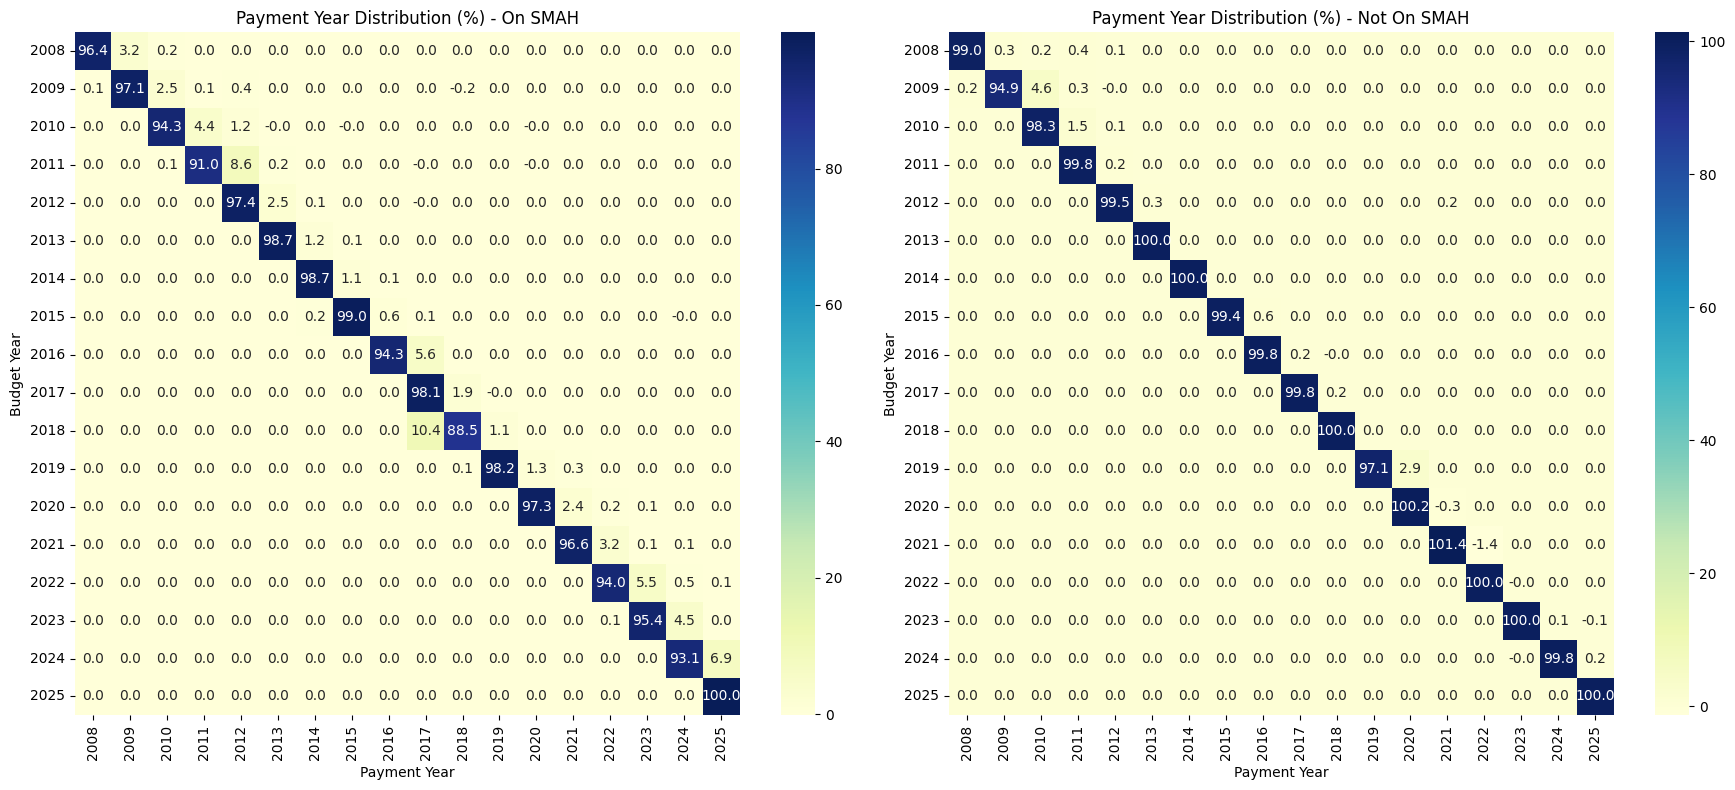

In [19]:
#copy of tashlumim shekel
tashlomim_copy = tashlomim_data_specific_coin.copy()

# on smah and not on smah matrix
on_smah_for_matrix = tashlomim_copy[tashlomim_copy["order_id"] != "#"]
not_on_smah_for_matrix = tashlomim_copy[tashlomim_copy["order_id"] == "#"]

# for each budget year have a payment years breakdown for mimun (matrix)
payment_matrix_on_smah = on_smah_for_matrix.pivot_table(index='budget_year', columns='payment_year', values='mimun', aggfunc='sum', fill_value=0)
payment_matrix_not_on_smah = not_on_smah_for_matrix.pivot_table(index='budget_year', columns='payment_year', values='mimun', aggfunc='sum', fill_value=0)

# make payment matrix as percentage of each budget year
payment_matrix_percentage_on_smah = payment_matrix_on_smah.div(payment_matrix_on_smah.sum(axis=1), axis=0) * 100
payment_matrix_percentage_not_on_smah = payment_matrix_not_on_smah.div(payment_matrix_not_on_smah.sum(axis=1), axis=0) * 100

#plot the 2 payment matrix pracentage as heatmap in same canvas
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
sns.heatmap(payment_matrix_percentage_on_smah, annot=True, fmt=".1f", ax=axes[0], cmap="YlGnBu")
axes[0].set_title('Payment Year Distribution (%) - On SMAH')
axes[0].set_xlabel('Payment Year')
axes[0].set_ylabel('Budget Year')
sns.heatmap(payment_matrix_percentage_not_on_smah, annot=True, fmt=".1f", ax=axes[1], cmap="YlGnBu")
axes[1].set_title('Payment Year Distribution (%) - Not On SMAH')
axes[1].set_xlabel('Payment Year')
axes[1].set_ylabel('Budget Year')
plt.tight_layout()
plt.show()



# breakdown of orders by budget years where payment year < budget year
### do this part only for shekel coin
### should blame 2018

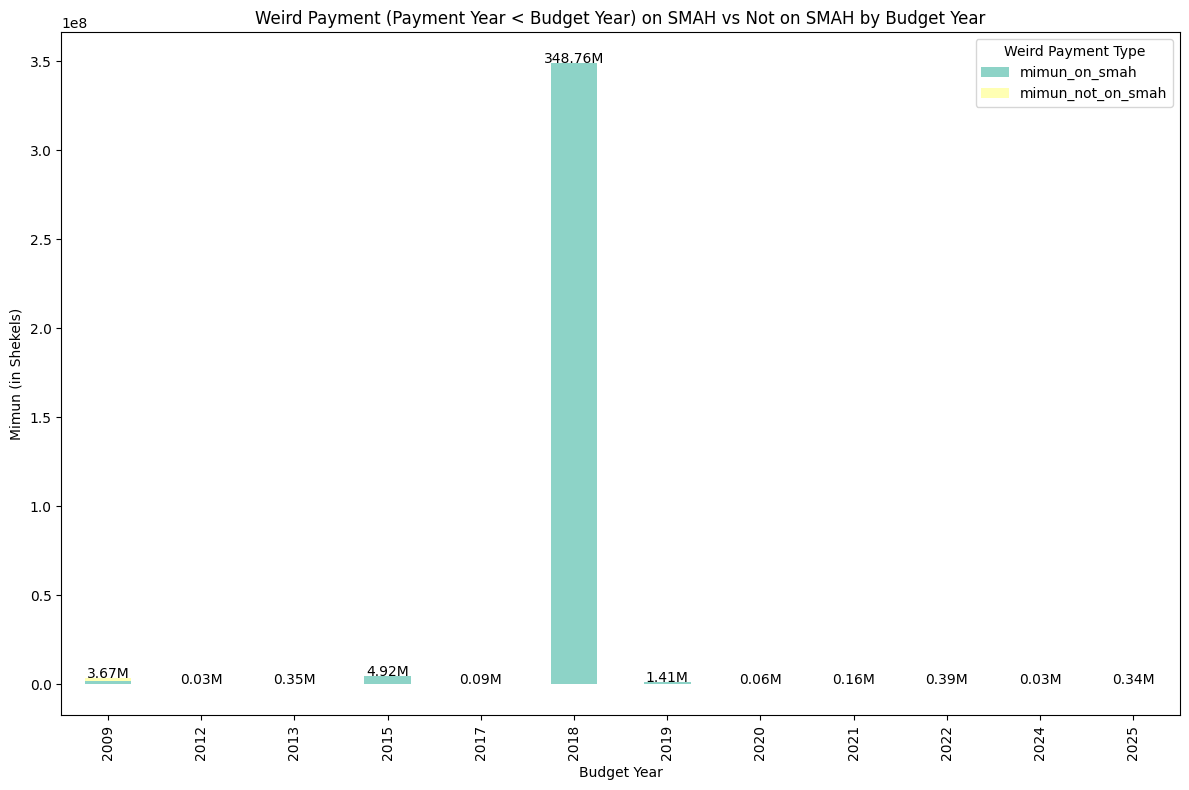

In [20]:
if(COIN_TO_INSPECT == 1):
    # make data of orders_id where payment_year < budget_year
    on_smah_for_matrix_weird_payment = on_smah_for_matrix[on_smah_for_matrix["payment_year"] < on_smah_for_matrix["budget_year"]]
    not_on_smah_for_matrix_weird_payment = not_on_smah_for_matrix[not_on_smah_for_matrix["payment_year"] < not_on_smah_for_matrix["budget_year"]]

    # take all the importent columns
    on_smah_for_matrix_weird_payment = on_smah_for_matrix_weird_payment[["order_id", "budget_year", "paymant_date", "mimun"]]
    not_on_smah_for_matrix_weird_payment = not_on_smah_for_matrix_weird_payment[["budget_year", "paymant_date", "mimun"]]

    # ignore all 0 in mimun
    on_smah_for_matrix_weird_payment = on_smah_for_matrix_weird_payment[on_smah_for_matrix_weird_payment["mimun"] != 0]
    not_on_smah_for_matrix_weird_payment = not_on_smah_for_matrix_weird_payment[not_on_smah_for_matrix_weird_payment["mimun"] != 0]

    # get weird payment data mimun grouped by budget year
    weird_payment_on_smah_grouped = on_smah_for_matrix_weird_payment.groupby("budget_year").agg({'mimun':'sum'})
    weird_payment_not_on_smah_grouped = not_on_smah_for_matrix_weird_payment.groupby("budget_year").agg({'mimun':'sum'})

    # combine the 2 weird payment data
    weird_payment_combined = pd.merge(weird_payment_on_smah_grouped, weird_payment_not_on_smah_grouped, on="budget_year", suffixes=('_on_smah', '_not_on_smah'))

    # plot weird payment combined data as stacked bar chart with labels on top of bars
    colors = sns.color_palette("Set3", 2)
    weird_payment_combined.plot(kind='bar', stacked=True, figsize=(12,8), color=colors)
    plt.title('Weird Payment (Payment Year < Budget Year) on SMAH vs Not on SMAH by Budget Year')
    plt.xlabel('Budget Year')
    plt.ylabel('Mimun (in Shekels)')
    for i in range(len(weird_payment_combined)):
        plt.text(i, weird_payment_combined.iloc[i].sum(), f"{weird_payment_combined.iloc[i].sum()/1e6:.2f}M", ha='center')
    plt.legend(title='Weird Payment Type')
    plt.tight_layout()
    plt.show()

# check what happend on smah 2018

### blame 2 single orders

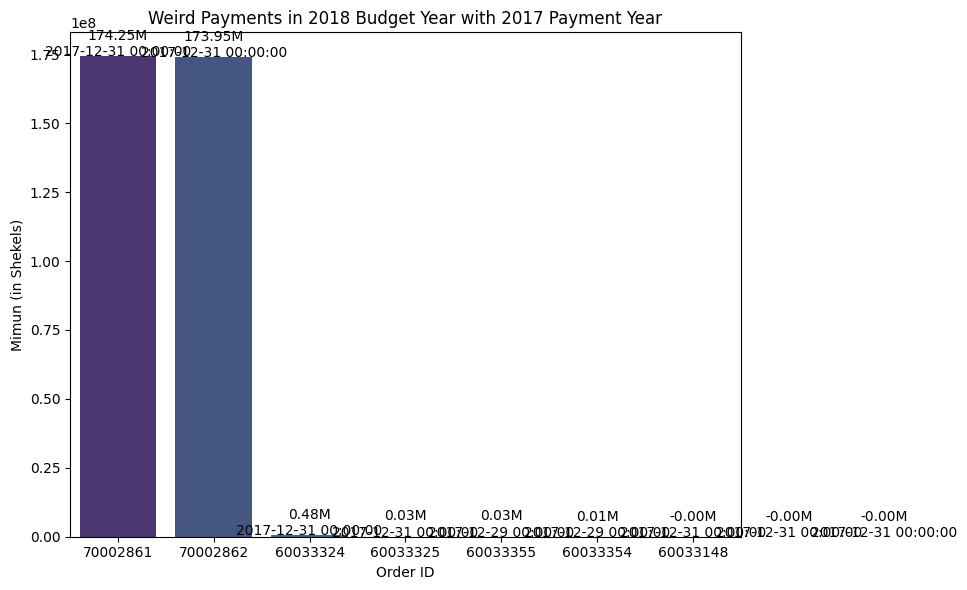

In [21]:
if(COIN_TO_INSPECT == 1):
    # check what happend on smah 2018
    on_smah_for_matrix_weird_payment["payment_year"] = on_smah_for_matrix_weird_payment["paymant_date"].dt.year.astype(int)
    on_smah_for_matrix_weird_payment_2018 = on_smah_for_matrix_weird_payment[(on_smah_for_matrix_weird_payment["budget_year"] == 2018) & (on_smah_for_matrix_weird_payment["payment_year"] == 2017)]
    on_smah_for_matrix_weird_payment_2018.set_index('order_id')
    on_smah_for_matrix_weird_payment_2018 = on_smah_for_matrix_weird_payment_2018[["order_id", "budget_year", "paymant_date", "mimun"]].sort_values(by='mimun', ascending=False)

    # plot it so i could show what order id couse the issue where payment date is in 2017 but budget year is 2018, add payment date in legend for each order id
    plt.figure(figsize=(10,6))
    sns.barplot(data=on_smah_for_matrix_weird_payment_2018, x='order_id', y='mimun', palette='viridis')
    plt.title('Weird Payments in 2018 Budget Year with 2017 Payment Year')
    plt.xlabel('Order ID')
    plt.ylabel('Mimun (in Shekels)')
    # add payment date in legend for each order id
    for i in range(len(on_smah_for_matrix_weird_payment_2018)):
        plt.text(i, on_smah_for_matrix_weird_payment_2018['mimun'].iloc[i], f"{on_smah_for_matrix_weird_payment_2018['mimun'].iloc[i]/1e6:.2f}M\n{on_smah_for_matrix_weird_payment_2018['paymant_date'].iloc[i]}", ha='center')
    plt.tight_layout()
    plt.show()

# tzinor rehesh sales

### first look at hazmanot that are way over the tashlumim and remove em

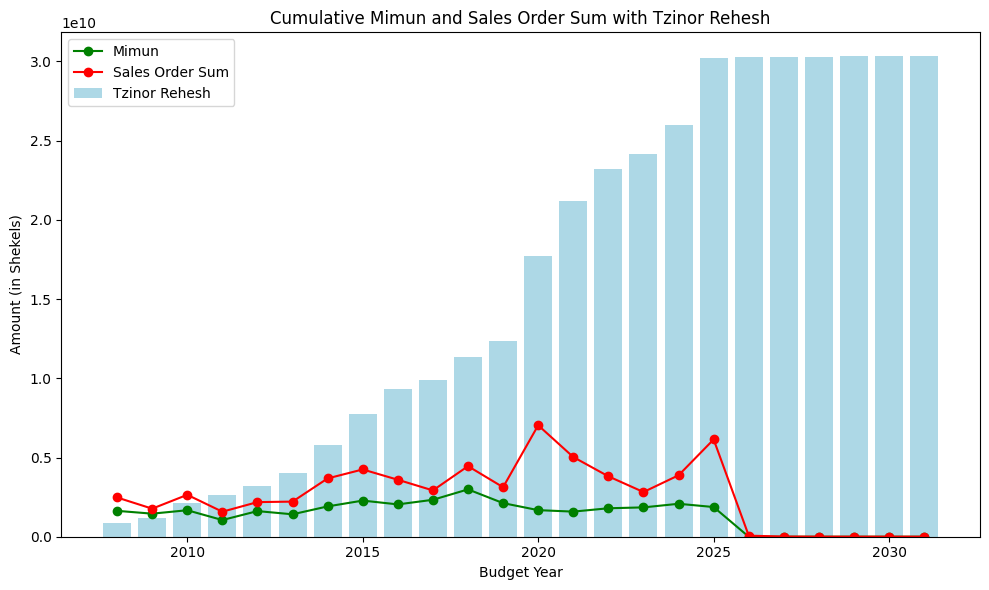

In [22]:
tashlomim_on_smah = tashlomim_data_specific_coin[tashlomim_data_specific_coin["order_id"] != "#"]
ts_tashlumim = tashlomim_on_smah.groupby("order_id").agg({'mimun': 'sum'})
ts_hazmanot = hazmanot_data_specific_coin.groupby("order_id").agg({'sales_order_sum': 'sum'})
# find hazmanot orders that tashlumim over hazmanot
combined_tashlumim_hazmanot_ts = ts_tashlumim.join(ts_hazmanot, how='left').fillna(0)
combined_tashlumim_hazmanot_ts["diff"] = combined_tashlumim_hazmanot_ts["mimun"] - combined_tashlumim_hazmanot_ts["sales_order_sum"]
combined_tashlumim_hazmanot_ts = combined_tashlumim_hazmanot_ts[combined_tashlumim_hazmanot_ts["diff"] > 0].sort_values(by="diff", ascending=False)
orders_hazmanot_that_over_tashlumim = combined_tashlumim_hazmanot_ts.index.values
# remove hazmanot orders that tashlumim over hazmanot
tashlumim_data_without_orders_hazmanot_that_over_tashlumim = tashlomim_on_smah[~(tashlomim_on_smah["order_id"].isin(orders_hazmanot_that_over_tashlumim))].groupby("payment_year").agg({'mimun': 'sum'})
hazmanot_data_without_orders_hazmanot_that_over_tashlumim = hazmanot_data_specific_coin[~(hazmanot_data_specific_coin["order_id"].isin(orders_hazmanot_that_over_tashlumim))].groupby("budget_year").agg({'sales_order_sum': 'sum'})
# align hazmanot orders that tashlumim over hazmanot
hazmanot_tzinor_align_without, tashlumim_tzinor_align_without = hazmanot_data_without_orders_hazmanot_that_over_tashlumim.align(tashlumim_data_without_orders_hazmanot_that_over_tashlumim, fill_value=0, axis=0)
# plot
plt.figure(figsize=(10,6))
plt.bar(tashlumim_tzinor_align_without.index, hazmanot_tzinor_align_without['sales_order_sum'].cumsum() - tashlumim_tzinor_align_without['mimun'].cumsum(), label='Tzinor Rehesh', color='lightblue')
plt.plot(tashlumim_tzinor_align_without.index, tashlumim_tzinor_align_without, label='Mimun', color='green', marker='o')
plt.plot(hazmanot_tzinor_align_without.index, hazmanot_tzinor_align_without, label='Sales Order Sum', color='red', marker='o')
plt.title('Cumulative Mimun and Sales Order Sum with Tzinor Rehesh')
plt.xlabel('Budget Year')
plt.ylabel('Amount (in Shekels)')
plt.legend()
plt.tight_layout()
plt.show()


# Pracentage Paid: First Year vs Second Year Tashlomim Age

### Scatter plot showing the percentage of payments in the first vs second year for each order.  
### Red dashed lines at 100%


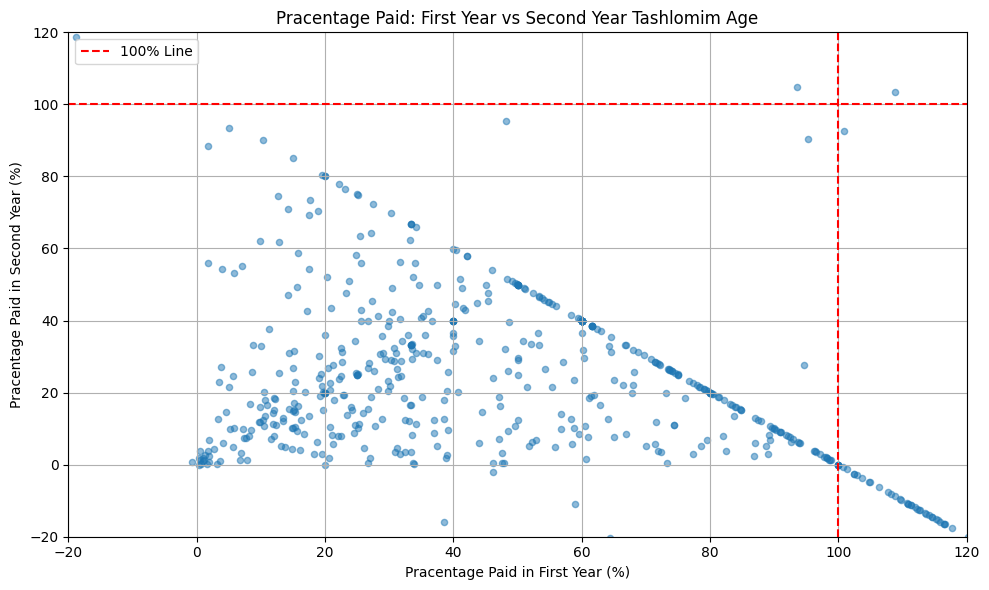

In [23]:
# find age of order ids in hazmanot shekel data
hazmanot_data_age = hazmanot_data_specific_coin.copy()
hazmanot_data_age["year_order_starting_date"] = pd.to_datetime(hazmanot_data_age["order_starting_date"]).dt.year.astype('Int64')
hazmanot_data_age["hazmanot_age"] = TODAY_YEAR - hazmanot_data_age["year_order_starting_date"]

# delete orders age less then 2 years
hazmanot_data_shekel_age = hazmanot_data_age[hazmanot_data_age["hazmanot_age"] >= 2]

# group by hazmanot age
hazmanot_age = hazmanot_data_shekel_age.groupby("order_id").agg({'sales_order_sum':'sum' ,'hazmanot_age': 'first'}).reset_index()

# tashlumim on smah
tashlomim_data_shekel_on_smah = tashlomim_data_specific_coin[tashlomim_data_specific_coin["order_id"] != "#"]

# tashlumim shekel data with only payment_date and order_id and mimun
tashlomim_payment_date = tashlomim_data_shekel_on_smah[["order_id", "payment_year", "mimun"]]

# tashlomim only on smah
tashlomim_only_on_smah = tashlomim_payment_date[tashlomim_payment_date["order_id"] != "#"]

# tashlomim data with hazmanot age
hazmanot_and_tashlomim_age = pd.merge(tashlomim_only_on_smah, hazmanot_age, on="order_id")

# pracentage of paid mimun vs sales order sum by hazmanot age
hazmanot_and_tashlomim_age["pracentage_paid"] = hazmanot_and_tashlomim_age["mimun"] / hazmanot_and_tashlomim_age["sales_order_sum"] * 100

# making tashlomim age that means 
hazmanot_and_tashlomim_age["tashlomim_age"] = hazmanot_and_tashlomim_age["payment_year"] - (TODAY_YEAR - hazmanot_and_tashlomim_age["hazmanot_age"])

# for each id_order see pracentage paid for first and second tashlumim age
hazmanot_tashlomim_age_summary = hazmanot_and_tashlomim_age.groupby(["order_id", "tashlomim_age"]).agg({'pracentage_paid': 'sum'}).reset_index()

# replace all inf and -inf with 0 because it means no payment made yet
hazmanot_tashlomim_age_summary["pracentage_paid"] = hazmanot_tashlomim_age_summary["pracentage_paid"].replace([np.inf, -np.inf], 0)
# take only first and second tashlomim age
hazmanot_tashlomim_age_summary = hazmanot_tashlomim_age_summary[hazmanot_tashlomim_age_summary["tashlomim_age"] <= 2]
# pivot the data for better plotting
first_year_tashlomim_age = hazmanot_tashlomim_age_summary[hazmanot_tashlomim_age_summary["tashlomim_age"] == 1]
second_year_tashlomim_age = hazmanot_tashlomim_age_summary[hazmanot_tashlomim_age_summary["tashlomim_age"] == 2]
merged_tashlomim_age = pd.merge(first_year_tashlomim_age, second_year_tashlomim_age, on="order_id", suffixes=('_first_year', '_second_year'))
merged_tashlomim_age = merged_tashlomim_age[["order_id", "pracentage_paid_first_year", "pracentage_paid_second_year"]]
# plot the data as point for each order id and x-axis is pracentage paid in first year and y-axis is pracentage paid in second year and add a line y=100 and x=100 
plt.figure(figsize=(10,6))
plt.scatter(merged_tashlomim_age["pracentage_paid_first_year"], merged_tashlomim_age["pracentage_paid_second_year"], s=20, alpha=0.5)
plt.title('Pracentage Paid: First Year vs Second Year Tashlomim Age')
plt.xlabel('Pracentage Paid in First Year (%)')
plt.ylabel('Pracentage Paid in Second Year (%)')
plt.xlim(-20, 120)
plt.ylim(-20, 120)
plt.grid(True)
plt.axhline(y=100, color='r', linestyle='--', label='100% Line')
plt.axvline(x=100, color='r', linestyle='--')
plt.legend()
plt.tight_layout()
plt.show()

# graph segmentations by 5 biggest ones

### Group by different fields in Hazmanot and Tashlumim data 

Dropdown(description='Year:', index=5, options=('All', 2021, 2022, 2023, 2024, 2025), style=DescriptionStyle(d…

Dropdown(description='Subject:', options=('sales_office', 'sales_organistion', 'sales_document_type', 'sales_g…

IntSlider(value=5, description='Top N:', max=20, min=1, style=SliderStyle(description_width='initial'))

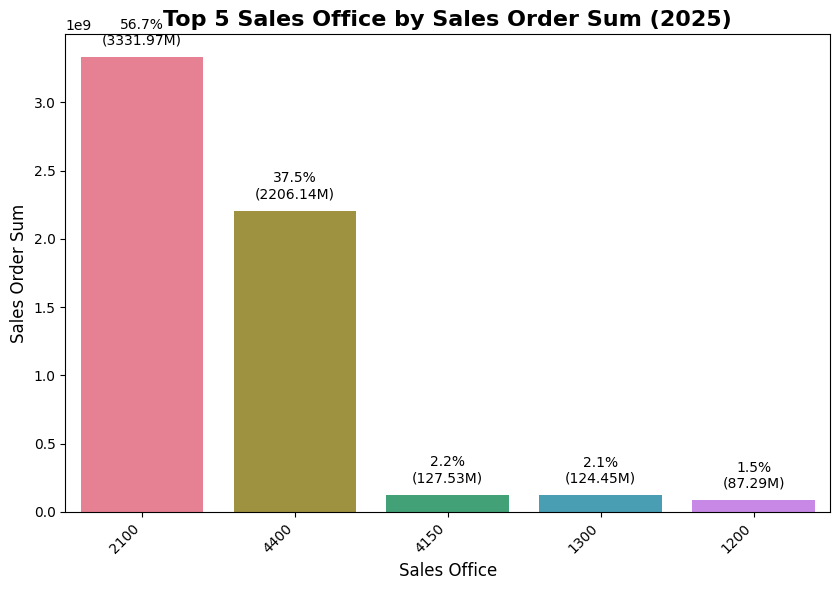

In [24]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ----------------------------------------
# Subjects
# ----------------------------------------
subjects_hazmanot = [
    "sales_office",
    "sales_organistion",
    "sales_document_type",
    "sales_group",
    "inviting_partner"
]

subjects_tashlomim = ["huka", "zroa", "fc4", "fc3"]
all_subjects = subjects_hazmanot + subjects_tashlomim

year_options = ["All", 2021, 2022, 2023, 2024, 2025]

# ----------------------------------------
# Widgets
# ----------------------------------------
year_dropdown = widgets.Dropdown(
    options=year_options,
    value=2025,
    description="Year:",
    style={"description_width": "initial"}
)

subject_dropdown = widgets.Dropdown(
    options=all_subjects,
    value=all_subjects[0],
    description="Subject:",
    style={"description_width": "initial"}
)

topn_slider = widgets.IntSlider(
    value=5,
    min=1,
    max=20,
    step=1,
    description="Top N:",
    style={"description_width": "initial"}
)

# ----------------------------------------
# Helper functions
# ----------------------------------------
def filter_year(df, year, year_col="budget_year"):
    if year == "All":
        return df[df[year_col].isin([2021, 2022, 2023, 2024, 2025])]
    return df[df[year_col] == year]


def add_percent_labels(ax, values):
    total = values.sum()
    ymax = values.max()

    for i, val in enumerate(values):
        pct = val / total * 100
        ax.text(
            i,
            val + ymax * 0.02,   # always just above the bar
            f"{pct:.1f}%\n({val/1e6:.2f}M)",
            ha="center",
            va="bottom",
            fontsize=10
        )

# ----------------------------------------
# Main plot function
# ----------------------------------------
def plot_subject(year, subject, top_n):
    clear_output(wait=True)
    display(year_dropdown, subject_dropdown, topn_slider)

    # Dataset & value column
    if subject in subjects_hazmanot:
        df = filter_year(hazmanot_data_specific_coin, year)
        value_col = "sales_order_sum"
        title_base = "Sales Order Sum"
    else:
        df = filter_year(tashlomim_data_specific_coin, year)
        value_col = "mimun"
        title_base = "Mimun"

    if df.empty:
        print("No data for selected year.")
        return

    # Group by subject
    group_data = (
        df.groupby(subject, dropna=True)[value_col]
        .sum()
        .reset_index()
    )

    group_data[value_col] = pd.to_numeric(group_data[value_col], errors="coerce")
    group_data = group_data[group_data[value_col] > 0]

    if group_data.empty:
        print("No positive values to display.")
        return

    # Top N
    top_data = (
        group_data
        .sort_values(value_col, ascending=False)
        .head(top_n)
        .sort_values(value_col, ascending=False)
    )

    # Explicit order (CRITICAL FIX)
    order = top_data[subject].tolist()

    # Dynamic figure width
    fig_width = min(1 + 1.5 * len(top_data), 16)
    plt.figure(figsize=(fig_width, 6))

    ax = sns.barplot(
        data=top_data,
        x=subject,
        y=value_col,
        order=order,
        palette=sns.color_palette("husl", len(top_data))
    )

    plt.title(
        f"Top {top_n} {subject.replace('_',' ').title()} by {title_base} ({year})",
        fontsize=16,
        fontweight="bold"
    )

    plt.xlabel(subject.replace("_", " ").title(), fontsize=12)
    plt.ylabel(title_base, fontsize=12)

    add_percent_labels(ax, top_data[value_col].values)

    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# ----------------------------------------
# Widget interactions
# ----------------------------------------
year_dropdown.observe(
    lambda change: plot_subject(year_dropdown.value, subject_dropdown.value, topn_slider.value),
    names="value"
)

subject_dropdown.observe(
    lambda change: plot_subject(year_dropdown.value, subject_dropdown.value, topn_slider.value),
    names="value"
)

topn_slider.observe(
    lambda change: plot_subject(year_dropdown.value, subject_dropdown.value, topn_slider.value),
    names="value"
)

# ----------------------------------------
# Initial display
# ----------------------------------------
display(year_dropdown, subject_dropdown, topn_slider)
plot_subject(year_dropdown.value, subject_dropdown.value, topn_slider.value)


# huka
##### define 'active huka' if in past_years mimun isnt 0

In [25]:
class HukaPlotter:
    def __init__(self, tashlomim_df, hazmanot_df):
        self.tashlomim_df = tashlomim_df
        self.hazmanot_df = hazmanot_df
        self.combined_df = None
        self.active_df = None
        self.top_hukas = None
        self.total_mimun = None
        self.active_hukas_list = []
        self.pracentage_of_biggest_combos = None
    def index_of_data_biggest_combos(self):
            return self.data_for_biggest_combo.index
    def plot_for_biggest_combos(self, number_of_biggest_combos, number_of_biggest_combos_years, past_years, fc_or_zroa_selected):
        """
        fc_or_zroa_selected: str, column to use instead of 'zroa'
        """
        if number_of_biggest_combos_years == "all years":
            self.data_for_biggest_combo = self.tashlomim_df[self.tashlomim_df["huka"].isin(self.active_hukas_list)
            ].groupby(["huka", "expediture_type", fc_or_zroa_selected, "doc_type"]) \
             .agg({"mimun":"sum"}).sort_values("mimun", ascending=False).head(number_of_biggest_combos)

            self.pracentage_of_biggest_combos = self.data_for_biggest_combo["mimun"].sum() / self.active_df["mimun_sum"].sum() * 100
        else:
            self.data_for_biggest_combo = self.tashlomim_df[
                (self.tashlomim_df["huka"].isin(self.active_hukas_list)) &
                (self.tashlomim_df["payment_year"].isin(past_years))
            ].groupby(["huka", "expediture_type", fc_or_zroa_selected, "doc_type"]) \
             .agg({"mimun":"sum"}).sort_values("mimun", ascending=False).head(number_of_biggest_combos)

            self.pracentage_of_biggest_combos = self.data_for_biggest_combo["mimun"].sum() / \
                self.active_df[self.active_df["year"].isin(past_years)]["mimun_sum"].sum() * 100

        print(self.data_for_biggest_combo)
        print(f"the pracentage of the biggest {number_of_biggest_combos} combos is {self.pracentage_of_biggest_combos}%")

    def update_plot(self,past_years, top_n, expenditure_type, number_of_biggest_combos_years):
        self.select_top_hukas(past_years, top_n, expenditure_type, number_of_biggest_combos_years)
        self.plot()

    def prepare_data(self):
        # Aggregate tashlomim
        tashlomim_agg = self.tashlomim_df.groupby(
            ["huka","expediture_type", "order_id", "payment_year"], as_index=False
        ).agg(mimun_sum=("mimun", "sum"))

        # Aggregate hazmanot
        hazmanot_agg = self.hazmanot_df.groupby(
            ["order_id", "budget_year"], as_index=False
        ).agg(sales_order_sum=("sales_order_sum", "sum"))

        # Merge
        self.combined_df = (
            tashlomim_agg.merge(
                hazmanot_agg,
                left_on=["order_id","payment_year"],
                right_on=["order_id","budget_year"],
                how="left"
            )
            .drop(columns="budget_year")
            .rename(columns={"payment_year":"year"})
            .fillna(0)
        )

    def select_top_hukas(self, past_years, top_n, expenditure_type, number_of_biggest_combos_years):
        # Active hukas
        if expenditure_type == "all":
            active_df = self.combined_df[self.combined_df["year"].isin(past_years)]
        elif expenditure_type == "20 and 45 together":
            active_df = self.combined_df[(self.combined_df["year"].isin(past_years)) & (self.combined_df["expediture_type"].isin([20,45]))]
        else:
            active_df = self.combined_df[(self.combined_df["year"].isin(past_years)) & (self.combined_df["expediture_type"] == expenditure_type)]
        active_sums = active_df.groupby("huka")["mimun_sum"].sum()
        self.active_hukas_list = active_sums[active_sums != 0].index.tolist()

        # Filter combined data
        self.active_df = self.combined_df[self.combined_df["huka"].isin(self.active_hukas_list)]

        # Top N hukas by all years or by active years
        if number_of_biggest_combos_years == "all years":
            top_huka_sums = self.active_df[self.active_df["year"].isin(ALL_YEARS_IN_DATA)] \
                                .groupby("huka")["mimun_sum"].sum() \
                                .sort_values(ascending=False)
        else:
            top_huka_sums = self.active_df[self.active_df["year"].isin(past_years)] \
                                .groupby("huka")["mimun_sum"].sum() \
                                .sort_values(ascending=False)
            
                                
        self.top_hukas = top_huka_sums.head(top_n).index.tolist()

        # Total mimun for percentages
        self.total_mimun = self.active_df["mimun_sum"].sum()

    def plot(self):
        plot_df = self.active_df[self.active_df["huka"].isin(self.top_hukas)] \
                    .groupby(["huka","year"], as_index=False) \
                    .agg({"mimun_sum":"sum", "sales_order_sum":"sum"})

        cols = 2
        rows = math.ceil(len(self.top_hukas)/cols)
        fig, axes = plt.subplots(rows, cols, figsize=(cols*8, rows*4))
        axes = axes.flatten()

        for i, huka in enumerate(self.top_hukas):
            ax = axes[i]
            huka_df = plot_df[plot_df["huka"] == huka].sort_values("year")

            # Mimun split by order_id
            huka_orders = self.active_df[self.active_df["huka"] == huka]
            huka_orders_grouped = huka_orders.groupby("order_id")["mimun_sum"].sum()
            on_smah_sum = huka_orders_grouped[huka_orders_grouped.index != "#"]
            not_on_smah_sum = huka_orders_grouped[huka_orders_grouped.index == "#"]

            on_smah_per_year = huka_orders[huka_orders["order_id"].isin(on_smah_sum.index)] \
                                .groupby("year")["mimun_sum"].sum()
            not_on_smah_per_year = huka_orders[huka_orders["order_id"].isin(not_on_smah_sum.index)] \
                                .groupby("year")["mimun_sum"].sum()

            years = sorted(huka_df["year"].unique())
            on_smah_values = [on_smah_per_year.get(y,0) for y in years]
            not_on_smah_values = [not_on_smah_per_year.get(y,0) for y in years]

            ax.bar(years, not_on_smah_values, label="Not on smah", color="#FF6F61", edgecolor="black")
            ax.bar(years, on_smah_values, bottom=not_on_smah_values, label="On smah", color="#4C72B0", edgecolor="black")

            if huka_df["sales_order_sum"].sum() != 0:
                ax.plot(years, huka_df["sales_order_sum"], marker="o", color="#FFA500", label="Sales", linewidth=2)

            mimun_of_huka = huka_df["mimun_sum"].sum()
            percentage = mimun_of_huka / self.total_mimun * 100
            ax.set_title(f"Huka {huka}: {percentage:.2f}% of total mimun", fontsize=11)
            ax.set_xticks(years)
            ax.set_xticklabels(years, rotation=45)
            ax.legend(fontsize=9)

        # Remove unused axes
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
        fig.suptitle(
            f"Top {len(self.top_hukas)} Huka – Mimun vs Sales by Year\n"
            f"Selected hukas represent {(plot_df['mimun_sum'].sum())/self.total_mimun*100:.2f}% of total active hukas",
            fontsize=16,
            fontweight="bold"
        )
        plt.tight_layout(rect=[0,0,1,0.95])
        plt.show()
    
# call the class
plotter = HukaPlotter(tashlomim_data_specific_coin, hazmanot_data_specific_coin)
plotter.prepare_data()

# make dropdown options
years_options = [
    [2022], [2023], [2024], [2025],
    [2022, 2023], [2023, 2024, 2025], [2022, 2023, 2024, 2025]
]
n_options = [5, 10 , 20, 30, 40, 50]
number_of_biggest_combos = [5, 10, 20, 30]
number_of_biggest_combos_years = ["active years", "all years"]
expenditure_type_options = [10, 20, 45, "all", "20 and 45 together"]
# make widget

active_years_dropdown = widgets.Dropdown(
    options=years_options,
    value=[2022, 2023, 2024, 2025],
    description='Select years:',
    disabled=False,
    style = {'description_width': 'initial'}
)
top_n_dropdown = widgets.Dropdown(
    options=n_options,
    value=10,
    description='Select top n:',
    disabled=False,
    style = {'description_width': 'initial'}
)
number_of_biggest_combos_years_dropdown = widgets.Dropdown(
    options=number_of_biggest_combos_years,
    value="active years",
    description='Select number of biggest combos years:',
    disabled=False,
    style = {'description_width': 'initial'},
    layout=widgets.Layout(width='400px')
)
expenditure_type_dropdown = widgets.Dropdown(
    options=expenditure_type_options,
    value=10,
    description='Select expenditure type:',
    disabled=False,
    style = {'description_width': 'initial'}
)


widgets.interact(plotter.update_plot,
                 past_years=active_years_dropdown,
                 top_n=top_n_dropdown,
                 expenditure_type = expenditure_type_dropdown,
                 number_of_biggest_combos_years = number_of_biggest_combos_years_dropdown)



interactive(children=(Dropdown(description='Select years:', index=6, options=([2022], [2023], [2024], [2025], …

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

# get data ready and look biggest combonations of huka - expediture type - zroa - doc type

In [26]:
number_of_biggest_combos_dropdown = widgets.Dropdown(
    options=number_of_biggest_combos,
    value=5,
    description='Select number of biggest combos:',
    disabled=False,
    style = {'description_width': 'initial'}
)
fc_or_zroa_options = ["fc3", "zroa"]  

fc_or_zroa_dropdown = widgets.Dropdown(
    options=fc_or_zroa_options,
    value=fc_or_zroa_options[0],
    description='Select column:',
    style={'description_width': 'initial'}
)

widgets.interact(
    plotter.plot_for_biggest_combos,
    number_of_biggest_combos=number_of_biggest_combos_dropdown,
    number_of_biggest_combos_years=number_of_biggest_combos_years_dropdown,
    past_years=active_years_dropdown,
    fc_or_zroa_selected=fc_or_zroa_dropdown
)


interactive(children=(Dropdown(description='Select number of biggest combos:', options=(5, 10, 20, 30), style=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

# inspect specific huka

In [27]:
class HukaDetailPlotter:
    def __init__(self, tashlomim_df, active_hukas_list):
        """
        tashlomim_df: original dataframe with columns
            ['payment_year','huka','expediture_type','zroa','doc_type','mimun']
        active_hukas_list: list of active hukas (from HukaPlotter)
        """
        self.tashlomim_df = tashlomim_df
        self.active_hukas_list = active_hukas_list
        self.huka_df = None
        self.fc_or_zroa_pivot = None
        self.doc_type_pivot = None
        self.expenditure_type_specific_huka = None
    
    def prepare_huka_data(self, huka_to_plot, fc_or_zroa_selected):
        """
        Prepares all the aggregated data for a specific huka.
        
        fc_or_zroa_selected: str, column name to use instead of 'zroa'
        """
        # Filter for active hukas and group
        active_huka_data = self.tashlomim_df[
            self.tashlomim_df["huka"].isin(self.active_hukas_list)
        ].groupby(["payment_year", "huka", "expediture_type", fc_or_zroa_selected, "doc_type"]) \
         .agg({"mimun": "sum"}).reset_index()

        # Filter for the specific huka
        self.huka_df = active_huka_data[active_huka_data["huka"] == huka_to_plot].sort_values("payment_year")

        # Aggregate by dynamic fc_or_zroa_selected and doc_type
        fc_or_zroa_data = self.huka_df.groupby(["payment_year", fc_or_zroa_selected]).agg({"mimun": "sum"}).reset_index()
        doc_type_data = self.huka_df.groupby(["payment_year", "doc_type"]).agg({"mimun": "sum"}).reset_index()
        self.expenditure_type_specific_huka = self.huka_df.groupby(["expediture_type"]).agg({"mimun": "sum"}).reset_index()

        # Percentage for expenditure type
        total_mimun = self.expenditure_type_specific_huka["mimun"].sum()
        self.expenditure_type_specific_huka["pracentage"] = (self.expenditure_type_specific_huka["mimun"] / total_mimun) * 100

        # Pivot using dynamic fc_or_zroa_selected
        self.fc_or_zroa_pivot = fc_or_zroa_data.pivot_table(
            index="payment_year",
            columns=fc_or_zroa_selected,
            values="mimun",
            aggfunc="sum",
            fill_value=0
        ).sort_index()

        self.doc_type_pivot = doc_type_data.pivot_table(
            index="payment_year",
            columns="doc_type",
            values="mimun",
            aggfunc="sum",
            fill_value=0
        ).sort_index()

    def plot(self):
        """
        Plots dynamic fc_or_zroa_selected stacked bar, Doc type stacked bar, and Expenditure type pie chart.
        """
        if self.huka_df is None:
            raise ValueError("Call prepare_huka_data(huka_to_plot, fc_or_zroa_selected) first!")

        # Colors
        fc_or_zroa_colors = sns.color_palette("Set2", n_colors=len(self.fc_or_zroa_pivot.columns))
        doc_type_colors = sns.color_palette("Set3", n_colors=len(self.doc_type_pivot.columns))
        expenditure_colors = sns.color_palette("Pastel1", n_colors=len(self.expenditure_type_specific_huka))

        # Explode largest pie slice
        explode = [0.1 if i == self.expenditure_type_specific_huka["pracentage"].idxmax() else 0 
                   for i in range(len(self.expenditure_type_specific_huka))]

        # Create subplots
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))

        # Dynamic fc_or_zroa_selected stacked bar
        self.fc_or_zroa_pivot.plot(
            kind="bar",
            stacked=True,
            ax=axes[0],
            color=fc_or_zroa_colors,
            edgecolor="black",
            width=0.8
        )
        axes[0].set_title(f"{self.fc_or_zroa_pivot.columns.name} stacked by year", fontsize=14)
        axes[0].set_xlabel("Year")
        axes[0].set_ylabel("Total mimun")
        axes[0].grid(axis="y", linestyle="--", alpha=0.5)
        axes[0].legend(title=self.fc_or_zroa_pivot.columns.name, bbox_to_anchor=(1.05, 1), loc="upper left")

        # Doc type stacked bar
        self.doc_type_pivot.plot(
            kind="bar",
            stacked=True,
            ax=axes[1],
            color=doc_type_colors,
            edgecolor="black",
            width=0.8
        )
        axes[1].set_title("Doc type stacked by year", fontsize=14)
        axes[1].set_xlabel("Year")
        axes[1].grid(axis="y", linestyle="--", alpha=0.5)
        axes[1].legend(title="Doc type", bbox_to_anchor=(1.05, 1), loc="upper left")

        # Expenditure type pie
        self.expenditure_type_specific_huka.plot(
            kind="pie",
            y="pracentage",
            labels=self.expenditure_type_specific_huka["expediture_type"],
            autopct="%.1f%%",
            explode=explode,
            colors=expenditure_colors,
            ax=axes[2],
            legend=False,
            startangle=140,
            shadow=True
        )
        axes[2].set_title("Expenditure type (% of total)", fontsize=14)
        axes[2].set_ylabel("")

        plt.tight_layout()
        plt.show()
# Instantiate
detail_plotter = HukaDetailPlotter(tashlomim_data_specific_coin, plotter.active_hukas_list)

# Prepare data for a specific huka
huka_options = plotter.active_hukas_list
huka_plot_dropdown = widgets.Dropdown(
    options=huka_options,
    value=huka_options[0],
    description='Select huka:',
    style={'description_width': 'initial'}
)


widgets.interact(
    lambda huka: [detail_plotter.prepare_huka_data(huka, fc_or_zroa_selected), detail_plotter.plot()],
    huka=huka_plot_dropdown
)



interactive(children=(Dropdown(description='Select huka:', options=(4030, 4040, 4060, 4270, 4271, 5270, 6040, …

<function __main__.<lambda>(huka)>

# start of forming forcast methedology


In [28]:
def make_ts(huka_to_inspect, fc_or_zroa_selected_value, fc_or_zroa_selected, expenditure_type, doc_type):
    active_hukas_list = plotter.active_hukas_list

    # Aggregate data
    active_huka_data = tashlomim_data_specific_coin[
        tashlomim_data_specific_coin["huka"].isin(active_hukas_list)
    ].groupby(["paymant_date","huka","expediture_type", fc_or_zroa_selected, "doc_type"]) \
     .agg({"mimun":"sum"}).reset_index().set_index("paymant_date").sort_index()

    # Filter one time series
    mask = (
        (active_huka_data["huka"] == huka_to_inspect) &
        (active_huka_data["doc_type"] == doc_type) &
        (active_huka_data[fc_or_zroa_selected] == fc_or_zroa_selected_value) &
        (active_huka_data["expediture_type"] == expenditure_type)
    )
    time_series = active_huka_data.loc[mask][["mimun"]].resample("ME").sum()
    time_series_pracentage = time_series["mimun"].sum() / active_huka_data["mimun"].sum() * 100

    # Fill missing months
    ts = time_series["mimun"].fillna(0)

    return ts

def describe_data(ts):
    print(ts.describe())

def zero_pracentage_in_data(ts):
    how_much_month_are_zero = ts[ts.values == 0].count()
    pracentage_of_zero = how_much_month_are_zero / ts.count()
    print(f"{pracentage_of_zero * 100}% of the data is zero")

def find_trend_and_rolling_std(ts):
    # Use as many points as available (up to window)
    rolling_std = ts.rolling(
        window=12,
        min_periods=2
    ).std().dropna()

    trend = ts.rolling(
        window=12,
        min_periods=1,
        center=True
    ).mean().dropna()

    trend, rolling_std = trend.align(rolling_std, join='inner')
    return trend, rolling_std

def plot_trend_vs_rolling_std(ts,trend, rolling_std,huka_to_inspect, zroa_or_fc3_to_inspect, expenditure_type):
    # --- Plot original series, trend, rolling std, and regression line ---
    plt.figure(figsize=(14,7))

    # Original time series
    plt.plot(ts, label='Original series', color='blue', alpha=0.4)

    # Trend (12-month moving average)
    plt.plot(trend, label='Trend (12-month MA)', color='red', linewidth=2)

    # Rolling standard deviation
    plt.plot(rolling_std, label='Rolling Std (12 months)', color='green', linewidth=2, linestyle='--')

    plt.title(f"Time Series Analysis\n huka: {huka_to_inspect} zroa_or_fc3: {zroa_or_fc3_to_inspect} expenditure type: {expenditure_type}", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# check if need model predcition
def variance_trend_diagnostics(trend, rolling_std):
    X = trend.values.reshape(-1, 1)
    y = rolling_std.values

    model = LinearRegression()
    model.fit(X, y)

    slope = float(model.coef_[0])
    r2 = float(model.score(X, y))

    # scale-free slope: elasticity approximation
    elasticity = slope * np.mean(trend) / np.mean(rolling_std)

    return slope, r2, elasticity, model.predict(X)

def plot_regression(trend, rolling_std, decomposition_type, elasticity, r2, model_prediction, reason):
    # --- Plot straight line in trend-space ---
    plt.figure(figsize=(10,5))
    plt.scatter(trend.values, rolling_std.values, label='Data', alpha=0.6)
    plt.plot(trend.values, model_prediction, color='red', label='Linear fit')
    plt.xlabel('Trend (12-month rolling mean)')
    plt.ylabel('Rolling std (12 months)')
    if decomposition_type == "multiplicative":
        plt.title(f"Linear Regression of Rolling Std vs Trend, elasticity = {elasticity:.2f}, R² score = {r2:.2f}\n → use multiplicative decomposition\n {reason}")
    else: 
        plt.title(f"Linear Regression of Rolling Std vs Trend, elasticity = {elasticity:.2f}, R² score = {r2:.2f}\n → use additive decomposition\n {reason}")
    plt.legend()
    plt.show()



def varience_explained(trend, seasonal, resid):
    total_var = (trend + seasonal + resid).var()

    # Compute fraction of variance of each component
    trend_var = trend.var() / total_var
    seasonal_var = seasonal.var() / total_var
    resid_var = resid.var() / total_var

    # If I look at how much the series moves up and down, what fraction of that movement comes from trend, seasonality, and irregular noise
    display(Markdown("### Variance Explained by Components"))
    display(Markdown(f"- **Trend:** {trend_var:.2%}"))
    display(Markdown(f"- **Seasonal:** {seasonal_var:.2%}"))
    display(Markdown(f"- **Residual:** {resid_var:.2%}"))
# monthly seasonal data
def compute_monthly_data(ts):
    monthly_seasonal_df = ts.to_frame(name='y')
    monthly_seasonal_df['month'] = monthly_seasonal_df.index.month

    return monthly_seasonal_df

def plot_monthly_seasonal(monthly_seasonal_df):
    sns.boxplot(x='month', y='y', data=monthly_seasonal_df) # showing median
    sns.lineplot(x='month', y='y', data=monthly_seasonal_df, color='red') # showing mean
    plt.title('Monthly Distribution with Mean Trend')
    plt.show()

def check_month_seasonality_distribution(monthly_seasonal_df):
    groups = [monthly_seasonal_df[monthly_seasonal_df['month'] == m]['y'] for m in range(1,13)]
    stat, p = kruskal(*groups)
    display(Markdown(f"### Kruskal-Wallis Test Result"))
    display(Markdown(f"- H-statistic: **{stat:.3f}**"))
    display(Markdown(f"- p-value: **{p:.4f}**"))

    if p < 0.05:
        display(Markdown("**→ At least one month differs significantly (seasonality detected)**"))
        posthoc = sp.posthoc_dunn(monthly_seasonal_df, val_col='y', group_col='month', p_adjust='bonferroni')
        display(Markdown("### Post-hoc Dunn Test (Bonferroni-adjusted p-values)"))
        print(posthoc)
    else:
        display(Markdown("## No significant differences between months"))
# residual anylsis

def plot_kde_for_normalitiy(data):
    sns.kdeplot(data, color='red')
    sns.histplot(data, bins=50, stat='density', color='blue', alpha=0.3)
    plt.title("time series desterbution")
    plt.show()
    
def data_monthly_var(data):
    monthly_var = data.groupby(data.index.month).var()
    yearly_std = np.sqrt(monthly_var.sum())
    return yearly_std 


# decompostion

In [29]:
def choose_decomposition(ts, r2_score, elasticity):
    use_multiplicative = (r2_score > R2_THRESHOLD_FOR_REGRESSION) and (elasticity > ELASTICITY_THRESHOLD_FOR_REGRESSION)
    has_negative = (ts < 0).any()
    has_zero = (ts == 0).any()

    if has_negative:
        return "additive", "negative values present in the data"
    elif has_zero and use_multiplicative:
        return "multiplicative", "zero values present in the data"
    elif use_multiplicative:
        return "multiplicative", "variance scales with level and no zero values in the data"
    else:
        return "additive", "variance roughly constant or weakly related"

def make_decompose(ts, decomposition_type="additive", period=12, robust=True):
    """
    Decompose a time series using STL.
    
    decomposition_type:
        - "additive": STL on original series
        - "multiplicative": log1p transform + STL (recommended)
    """

    if decomposition_type == "multiplicative":
        ts_used = np.log1p(ts)
    else:
        ts_used = ts.copy()

    stl = STL(ts_used, period=period, robust=robust)
    res = stl.fit()

    return res

def extract_decomposition(decomposition):
    return decomposition.trend, decomposition.seasonal, decomposition.resid
 
def plot_decomposition(decomposition):
    fig = decomposition.plot()
    fig.set_size_inches(12, 8)  
    plt.show()


# spikes

In [30]:
# ==========================
# Configuration
# ==========================
fc_or_zroa_selected = 'fc3'  # replace with your dynamic column
KEYS = ['huka', 'expediture_type', fc_or_zroa_selected, 'doc_type']
FULL_KEYS = KEYS + ['paymant_date']

original_data_daily = (
    tashlomim_data_specific_coin
    .groupby(FULL_KEYS, as_index=False)
    .agg(mimun=('mimun', 'sum'))
    .sort_values('paymant_date')
)
# ==========================
# Spike Detection Class
# ==========================
class SpikeDetection:
    """
    Detects spikes in time series data, interpolates them, and allows plotting.
    """
    def __init__(self, data, keys=KEYS, rolling_window=ROLLING_WINDOW,
                 min_points=MIN_POINTS, deviation_threshold=DEVIATION_THRESHOLD):
        self.data = data.copy()
        self.keys = keys
        self.rolling_window = rolling_window
        self.min_points = min_points
        self.deviation_threshold = deviation_threshold
        self.flagged_as_spikes = None
        self.cleaned_data = None

    def interpolate_group(self, group):
        """
        Interpolates NaN values in 'mimun' using time-based interpolation.
        """
        group = group.sort_values('paymant_date').set_index('paymant_date')
        group['mimun'] = group['mimun'].interpolate(method='time')
        return group.reset_index()

    def find_spikes(self):
        """
        Detect spikes using rolling mean/std and z-score method.
        """
        df = self.data

        # Rolling mean and std
        df['rolling_mean'] = df.groupby(self.keys)['mimun'].transform(
            lambda x: x.rolling(window=self.rolling_window, min_periods=self.min_points).mean()
        )
        df['rolling_std'] = df.groupby(self.keys)['mimun'].transform(
            lambda x: x.rolling(window=self.rolling_window, min_periods=self.min_points).std()
        )

        # Deviation (z-score like)
        df['deviation'] = (df['mimun'] - df['rolling_mean']).abs() / df['rolling_std']

        # Flag spikes
        self.flagged_as_spikes = df[df['deviation'] > self.deviation_threshold]
        df['is_spike'] = df.index.isin(self.flagged_as_spikes.index)

        # Replace spikes with NaN
        df.loc[df['is_spike'], 'mimun'] = np.nan

        self.data = df
        # Interpolate cleaned data
        self.cleaned_data = df.groupby(self.keys, group_keys=False).apply(self.interpolate_group)

        return self.data, self.flagged_as_spikes, self.cleaned_data

    def summary_spikes(self):
        """
        Print a summary of spikes detected.
        """
        num_spikes = self.data['is_spike'].sum()
        percent_spikes = num_spikes / len(self.data) * 100
        print(f"Total of {num_spikes} out of {len(self.data)} rows were flagged as spikes ({percent_spikes:.2f}%).")

    def plot_sample_timeseries(self, sample_key, original_data):
        """
        Plot original vs cleaned time series and highlight spikes.
        """
        # Filter helper
        def filter_df(df):
            mask = np.ones(len(df), dtype=bool)
            for k in self.keys:
                mask &= df[k] == sample_key[k]
            return df[mask].sort_values('paymant_date')

        original = filter_df(original_data)
        cleaned = filter_df(self.cleaned_data)
        spikes = filter_df(self.flagged_as_spikes)

        plt.figure(figsize=(14, 6))
        plt.plot(original['paymant_date'], original['mimun'], label='Original', marker='o')
        plt.plot(cleaned['paymant_date'], cleaned['mimun'], label='Cleaned', marker='o')
        plt.scatter(spikes['paymant_date'], spikes['mimun'], color='red', label='Flagged Spikes', zorder=5)
        plt.title('Original vs Cleaned Mimun Time Series')
        plt.xlabel('Payment Date')
        plt.ylabel('Mimun')
        plt.legend()
        plt.tight_layout()
        plt.show()



# time series start analysis

In [31]:
class TimeSeriesAnalysis:
    def __init__(self, ts):
        self.ts = ts
        self.count = ts.count()
        self.mean = ts.mean()
        self.std_before = ts.std()
        self.zeros_pct = (ts == 0).mean()
        self.cv_before = self.std_before / self.mean if self.mean != 0 else 0
        self.std_after = None
        self.cv_after = None
        self.std_improvement = None

    def _plot_summary(self, title, summary_text, warnings):
        fig, ax = plt.subplots(figsize=(7,4))
        ax.axis('off')
        ax.text(
            0.5, 0.5,
            f"{title}\n\n{summary_text}\n\n{warnings}",
            ha='center', va='center',
            fontsize=13,
            fontfamily='monospace',
            bbox=dict(boxstyle="round,pad=0.5", facecolor="#f0f0f0", edgecolor="#cccccc")
        )
        plt.show()

    def plot_ts_summary(self):
        summary_text = (
            f"Count of observations: {self.count}\n"
            f"Percentage of zeros: {self.zeros_pct:.2%}\n"
            f"Std / Mean (CV): {self.cv_before:.2%}"
        )

        warning1 = (
            "Warning: CV > 100%, data highly variable"
            if self.cv_before > 1 else
            "CV under 100%, data moderately variable"
        )

        warning2 = (
            "Warning: more than 50% zeros, sparse series"
            if self.zeros_pct > 0.5 else
            "Most data is not zero, series not sparse"
        )

        self._plot_summary("Time Series Summary", summary_text, f"{warning1}\n{warning2}")

    def plot_ts_summary_after_dealing_spikes(self, cleaned_ts):
        self.std_after = cleaned_ts.std()
        self.cv_after = self.std_after / cleaned_ts.mean() if cleaned_ts.mean() != 0 else 0
        # Compute improvement
        self.std_improvement = (self.std_before - self.std_after) / self.std_before

        summary_text = (
            f"Std / Mean (CV) after cleaning: {self.cv_after:.2%}\n"
            f"Std improvement: {self.std_improvement:.2%}"
        )

        self._plot_summary("Time Series Summary After Dealing with Spikes", summary_text, "")


# fill inactive months

In [32]:
# till the selected date make the time series missing month zero becouse we know there was no activity
def fill_inactive_months(ts):
    actual_last_date_in_data = pd.Timestamp(year=TODAY_YEAR, month=ACTUAL_LAST_MONTH_IN_DATA, day=1) + pd.offsets.MonthEnd(0)
    last_date_in_ts = ts.index.max()
    if last_date_in_ts < actual_last_date_in_data:
        all_months_index = pd.date_range(
            start=ts.index.min(),
            end=actual_last_date_in_data,
            freq='M'
        )
        ts = ts.reindex(all_months_index, fill_value=0)
    return ts


# check if ts is active

In [33]:
class TimeSeriesInspector:
    ROLLING_WINDOW = 24
    ACTIVITY_THRESHOLD = 0
    ACTIVITY_RATIO_THRESHOLD = 0.5
    QUANTILE = 0.25

    def __init__(self, ts: pd.Series):
        self.ts = ts.copy()
        self.ts.index = self.ensure_datetime_index(self.ts.index)
        self.ts.index = self.align_to_month_end(self.ts)
        self.activity_ratio = None
        self.rolling_mean = None
        self.rolling_std = None
        self.cv = None
        self.magnitude_thresh = None

    @staticmethod
    def ensure_datetime_index(index):
        if not isinstance(index, pd.DatetimeIndex):
            return pd.to_datetime(index)
        return index

    @staticmethod
    def align_to_month_end(ts: pd.Series) -> pd.DatetimeIndex:
        return ts.index + pd.offsets.MonthEnd(0)

    def compute_activity_ratio(self):
        is_active = self.ts > self.ACTIVITY_THRESHOLD
        self.activity_ratio = is_active.rolling(self.ROLLING_WINDOW, min_periods=1).mean()

    def compute_statistics(self):
        ts_positive = self.ts[self.ts > 0]
        self.magnitude_thresh = ts_positive.quantile(self.QUANTILE) if not ts_positive.empty else 0
        self.rolling_mean = self.ts.rolling(self.ROLLING_WINDOW).mean()
        self.rolling_std = self.ts.rolling(self.ROLLING_WINDOW).std()
        self.cv = self.rolling_std / self.rolling_mean.abs()

    def find_last_inactive_period(self, months=None):
        if months is None:
            months = self.ROLLING_WINDOW
        if self.activity_ratio is None:
            return None
        for date in reversed(self.activity_ratio.index):
            window = self.activity_ratio.loc[date:date + pd.DateOffset(months=months)]
            if window.values.sum() == 0:
                return window
        return None

    def determine_first_valid_date(self):
        inactive_period = self.find_last_inactive_period()
        first_date_of_active_ts = inactive_period.index[-1] if inactive_period is not None else self.ts.index[0]

        valid = (
            (self.activity_ratio >= self.ACTIVITY_RATIO_THRESHOLD) &
            (self.rolling_mean >= self.magnitude_thresh)
        )

        first_date_of_valid_ts = self.ts.index[0]
        if valid.any():
            first_date_of_valid_ts = valid[valid.values].index[0]

        return max(first_date_of_active_ts, first_date_of_valid_ts)

    def get_clean_active_ts(self):
        self.compute_activity_ratio()
        self.compute_statistics()
        first_date_to_use = self.determine_first_valid_date()
        return self.ts.loc[first_date_to_use:]


# start of inspecting time series

In [34]:
class TSSelector:
    def __init__(self, plotter, fc_or_zroa_selected="zroa"):
        """
        plotter: instance of HukaPlotter
        fc_or_zroa_selected: column name to use instead of 'zroa' (e.g., "zroa" or "fc3")
        """
        self.plotter = plotter
        self.fc_or_zroa_selected = fc_or_zroa_selected

        # Get the list of biggest combos (after plot_for_biggest_combos has been called)
        self.key_for_biggest_combo = plotter.index_of_data_biggest_combos().to_list()

        # Attributes to store selected time series info
        self.original_ts = None
        self.huka = None
        self.expenditure_type = None
        self.fc_or_zroa_value = None
        self.doc_type = None

        # Dropdown for selecting a combo (huka, expenditure, fc_or_zroa value, doc_type)
        self.combo_ts_dropdown = widgets.Dropdown(
            options=[
                (f"huka={h}, exp={e}, {self.fc_or_zroa_selected}={z}, doc={d}", (h, e, z, d))
                for h, e, z, d in self.key_for_biggest_combo
            ],
            description="Select combo:",
            layout=widgets.Layout(width="650px"),
            style={"description_width": "initial"}
        )

    def choose_ts_combination(self, ts_combination):
        # Unpack selected combo
        self.huka, self.expenditure_type, self.fc_or_zroa_value, self.doc_type = ts_combination

        # Generate the corresponding time series
        self.original_ts = make_ts(
            huka_to_inspect=self.huka,
            fc_or_zroa_selected_value=self.fc_or_zroa_value,
            fc_or_zroa_selected=self.fc_or_zroa_selected,
            expenditure_type=self.expenditure_type,
            doc_type=self.doc_type
        )


# Create selector instance
ts = TSSelector(plotter, fc_or_zroa_selected=fc_or_zroa_selected)

# Connect widget interaction
widgets.interact(
    ts.choose_ts_combination,
    ts_combination=ts.combo_ts_dropdown
)


interactive(children=(Dropdown(description='Select combo:', layout=Layout(width='650px'), options=(('huka=5270…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## Summary of Original Time Series

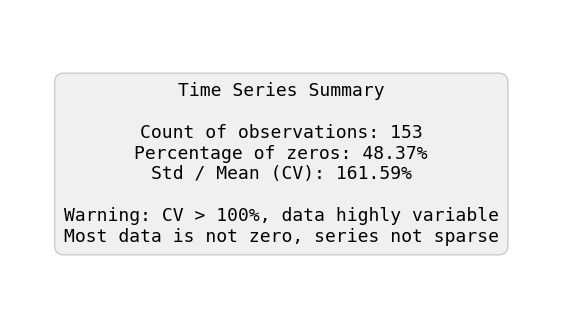

## Distribution of the Time Series

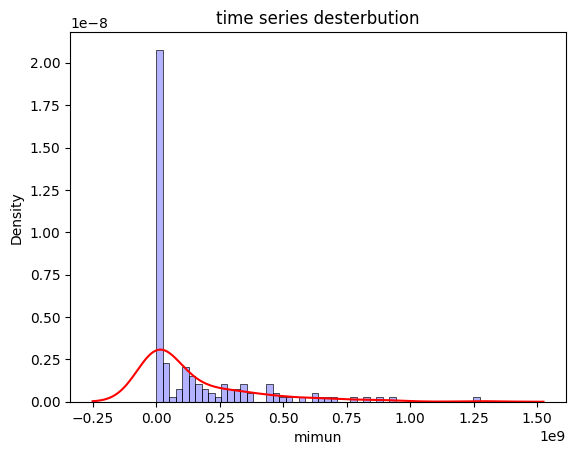

## original time series monlty values

Total of 1492 out of 89667 rows were flagged as spikes (1.66%).


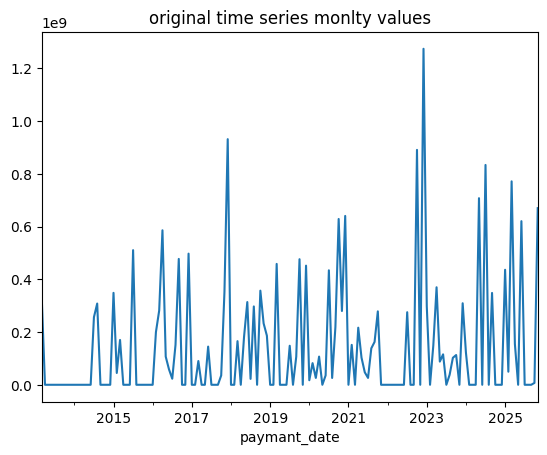

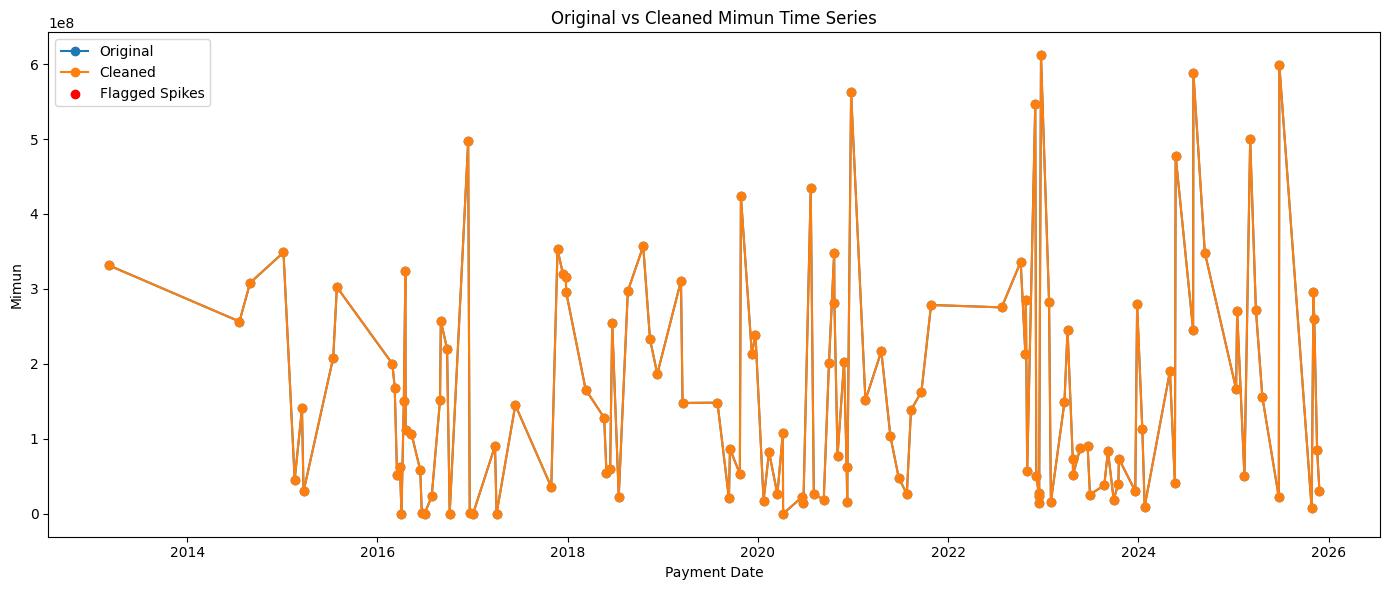

## time series cleaned and active 


## Trend vs Rolling Standard Deviation Analysis

This analysis examines whether the **variability of the series changes with its level**.

If the variance **increases as the trend increases**, this indicates a **multiplicative structure** rather than an additive one.

### What we examine:

- **Trend**: estimated using a centered moving average to capture long-term level changes.
- **Rolling standard deviation**: measures local variability around the trend.
- **Key diagnostic**: whether variability scales with the trend level.

### Interpretation:

- If rolling standard deviation **increases with the trend**, fluctuations scale with the level  
  → suggests **multiplicative decomposition**
- If rolling standard deviation is **roughly constant**, variability is independent of level  
  → suggests **additive decomposition**


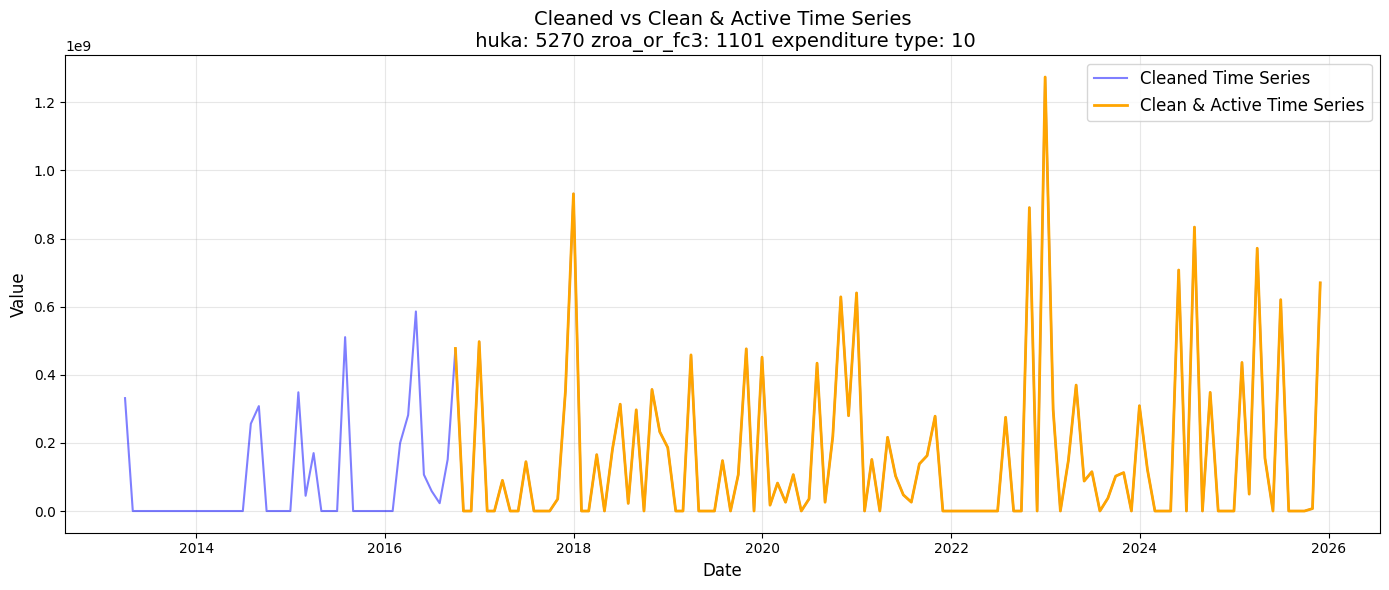

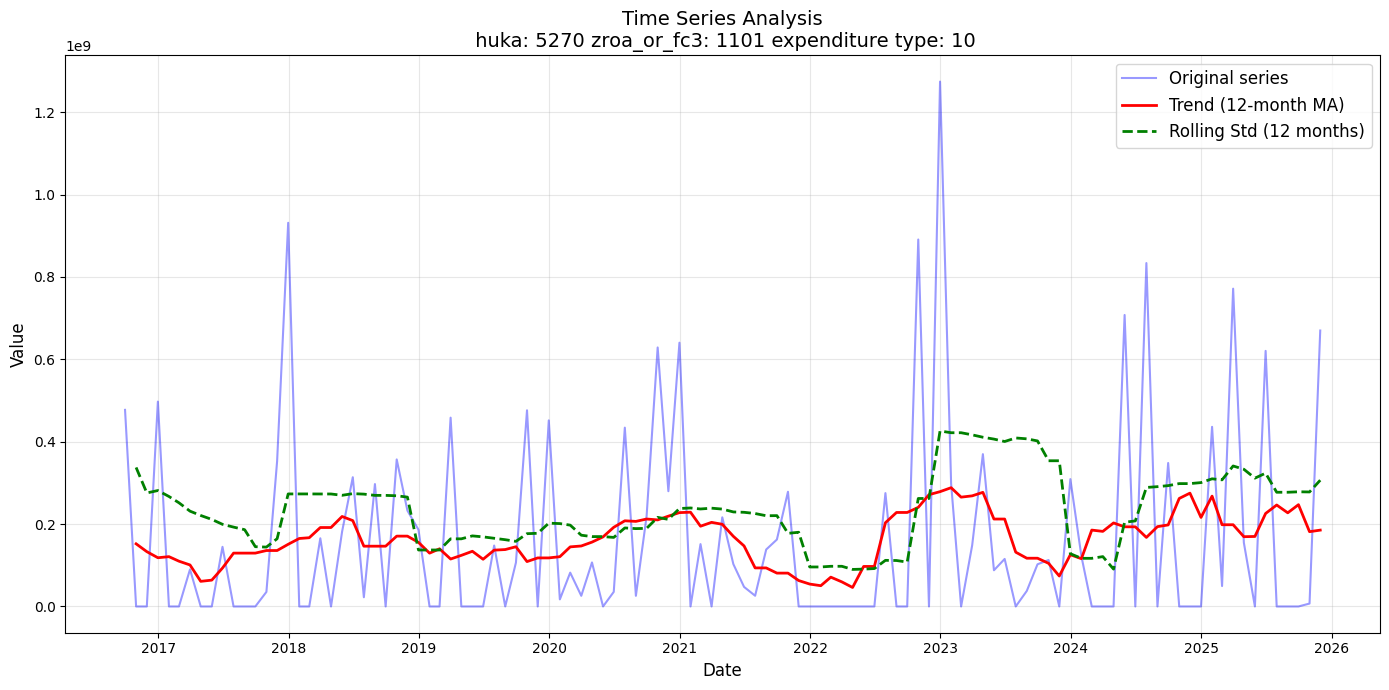


### Trend vs Rolling Std – Formal Regression Test

To quantify whether variability grows with the trend, we fit a **linear regression** between the rolling standard deviation and the trend.

$$
\text{rolling\_std} = \alpha + \beta \cdot \text{trend} + \epsilon
$$

### Interpretation of parameters:

- $\alpha$ (intercept): baseline variability when the trend is near zero  
- $\beta$ (slope): rate at which variability changes as the trend increases  
- $\epsilon$: unexplained noise

### Decision logic:

- $\beta > 0$ and meaningful fit → variability increases with level → **multiplicative pattern**
- $\beta \approx 0$ → variability independent of level → **additive pattern**


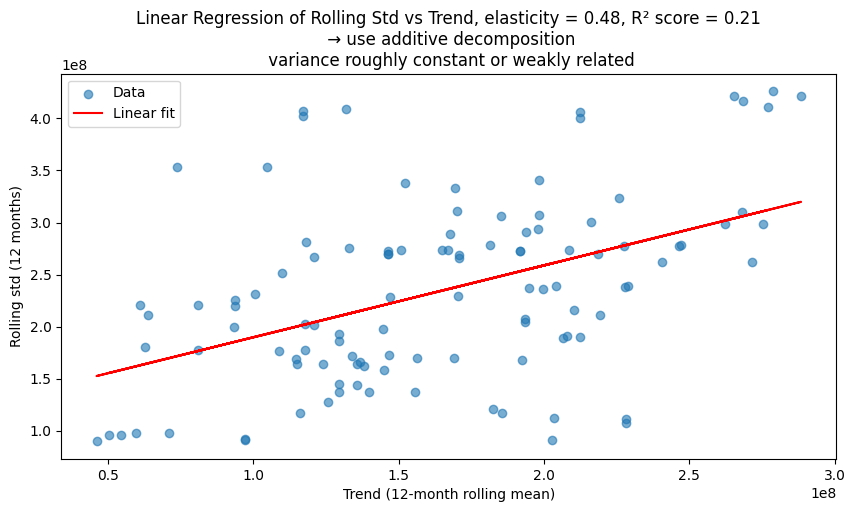


## Time Series Decomposition

We decompose the observed time series \( y_{t} \) into three components:

$$
y_{t} = T_{t} + S_{t} + R_{t}
$$

### Components:

- **Trend** \( T_{t} \): long-term movement, estimated via centered moving average  
- **Seasonality** \( S_{t} \): systematic, calendar-related effects  
- **Residuals** \( R_{t} \): irregular noise and unexplained variation

### Intermediate step:

- **Detrended series**:  
  \[
  y_{t} - T_{t} = S_{t} + R_{t}
  \]

Seasonality is estimated by averaging the detrended values across the same seasonal period.


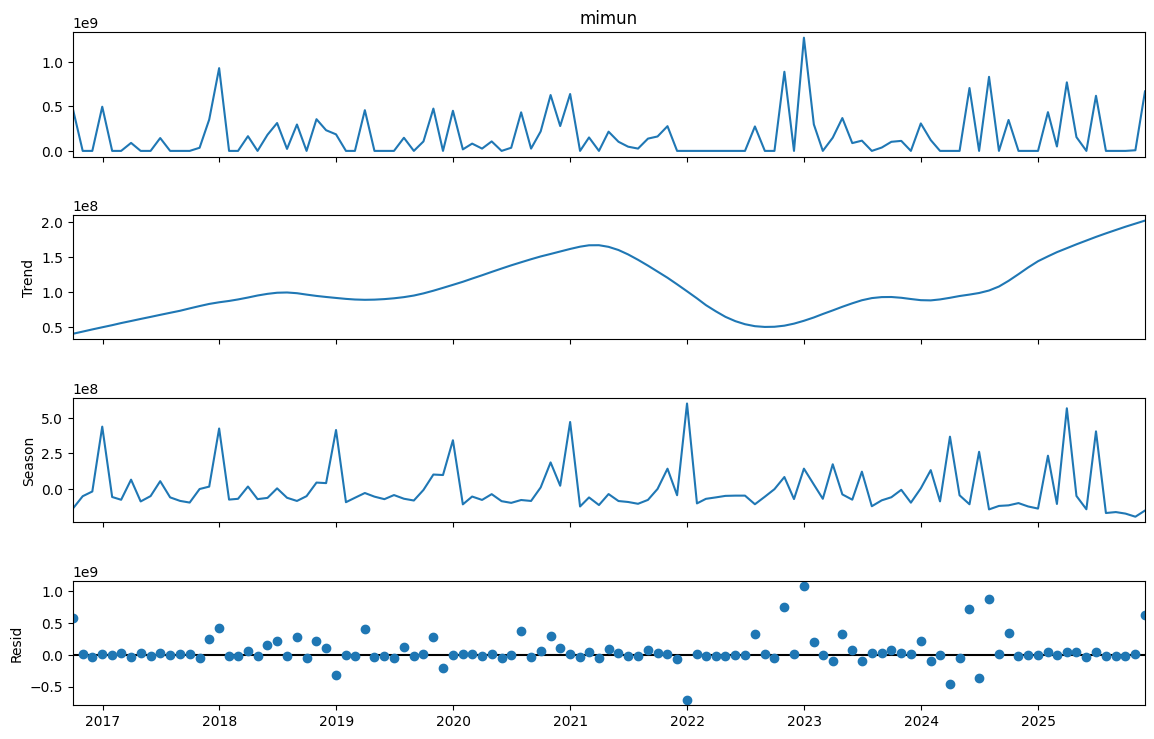

## Variance Explained by Decomposition Components

### Variance Explained by Components

- **Trend:** 2.50%

- **Seasonal:** 41.19%

- **Residual:** 83.87%


## Monthly Seasonality – Distribution Shape

Boxplots are used to compare **monthly distributions** and inspect skewness.

### Rule of thumb:

- **Right-skewed distribution** → mean **above** median  
- **Left-skewed distribution** → mean **below** median

This helps interpret whether extreme values systematically pull the average up or down for specific months.


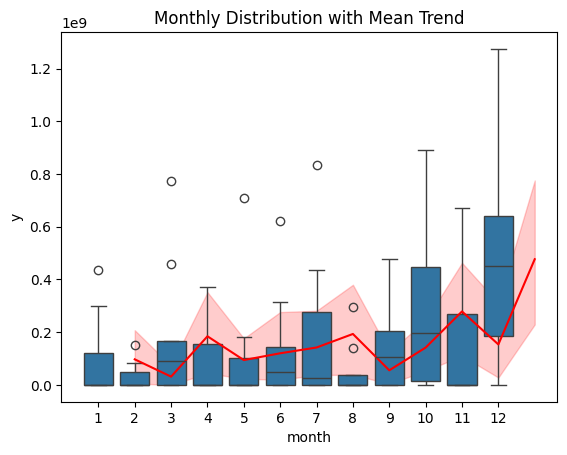


## Monthly Seasonality – Kruskal–Wallis Test

We use the **Kruskal–Wallis test** to determine whether **monthly observations come from the same distribution**.

This non-parametric test is appropriate when data is skewed or contains many zeros.

### Hypotheses:

- **Null hypothesis** \( H_0 \): all months follow the same distribution  
- **Alternative hypothesis** \( H_1 \): at least one month differs

### Interpretation:

- \( p < 0.05 \) → reject \( H_0 \) → evidence of monthly seasonality  
- \( p \ge 0.05 \) → fail to reject \( H_0 \) → no strong evidence of differences


### Kruskal-Wallis Test Result

- H-statistic: **16.303**

- p-value: **0.1302**

## No significant differences between months

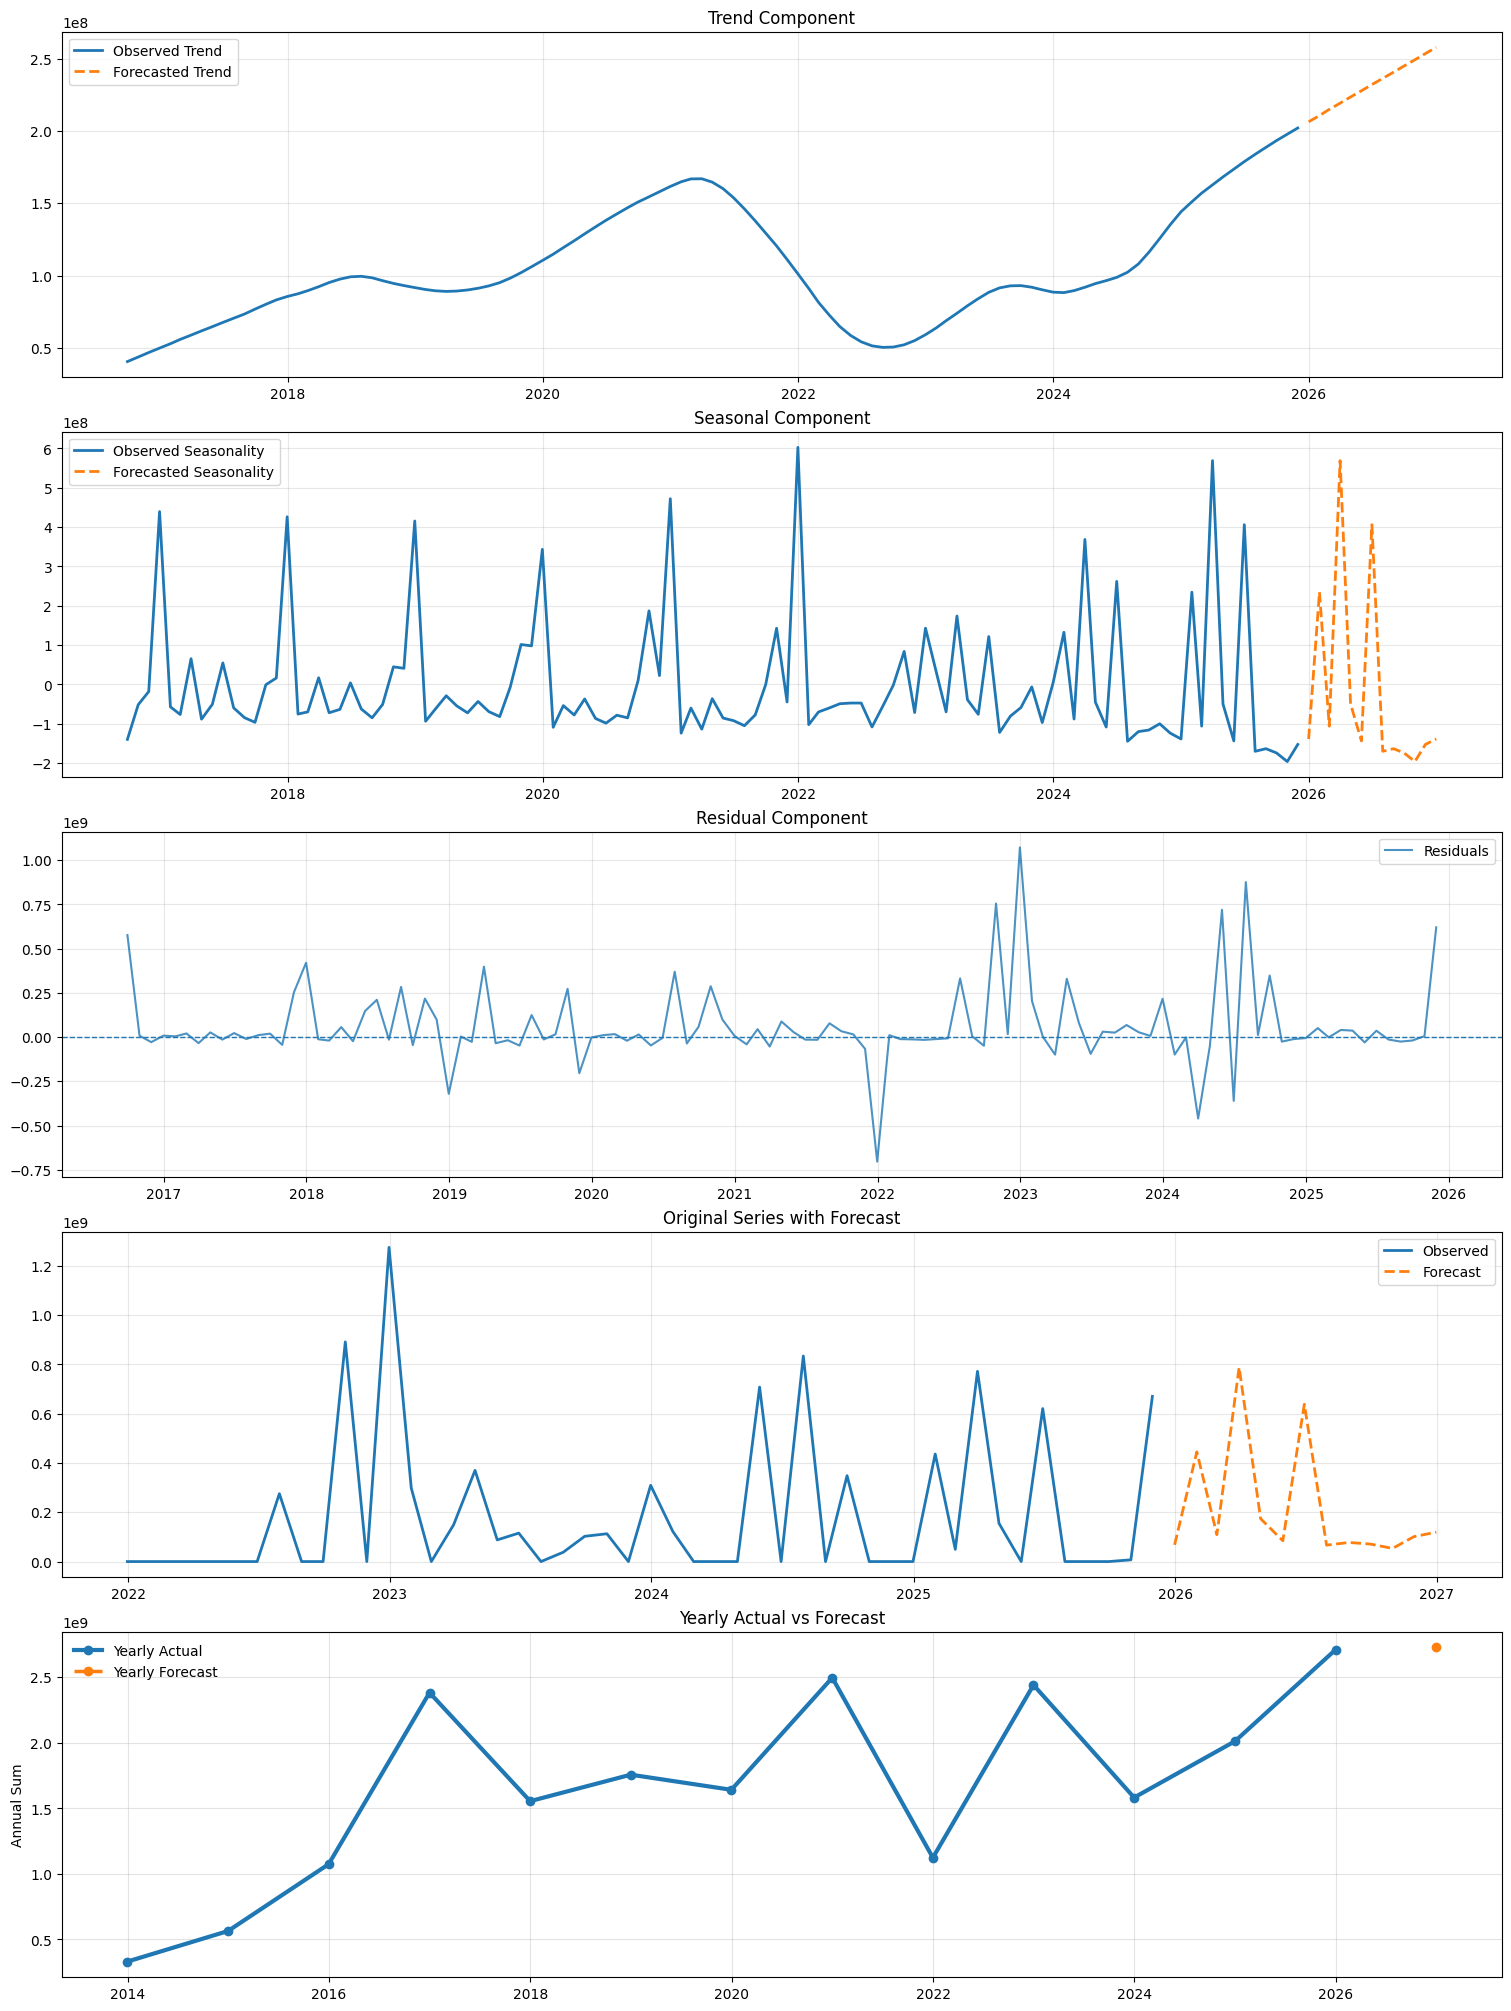

In [35]:
ts_original = ts.original_ts
huka_to_inspect = ts.huka
zroa_or_fc3_to_inspect = ts.fc_or_zroa_value
expenditure_type_to_inspect = ts.expenditure_type
doc_type_to_inspect = ts.doc_type

# fill missing months with zero 
ts_original = fill_inactive_months(ts_original)

# -----------------------------
# Step 1: Initial summary of the original time series
# Purpose: understand scale, sparsity, and overall variability
# -----------------------------
display(Markdown("## Summary of Original Time Series"))
summary_ts_plotter = TimeSeriesAnalysis(ts_original)
summary_ts_plotter.plot_ts_summary()

# -----------------------------
# Step 2: Inspect the distribution shape
# Purpose: assess skewness, non-normality, and heavy tails
# -----------------------------
display(Markdown("## Distribution of the Time Series"))
plot_kde_for_normalitiy(ts_original)

# -----------------------------
# Step 3: plotting the original time series
# -----------------------------
display(Markdown("## original time series monlty values"))
ts_original.plot(title = "original time series monlty values")

# -----------------------------
# Step 3: Identify extreme residual spikes
# Purpose: detect abnormal observations that inflate variance
# -----------------------------
KEYS = ['huka', 'expediture_type', fc_or_zroa_selected, 'doc_type']
FULL_KEYS = KEYS + ['paymant_date']


original_data_daily = (
    tashlomim_data_specific_coin
    .groupby(FULL_KEYS, as_index=False)
    .agg(mimun=('mimun', 'sum'))
    .sort_values('paymant_date')
)

spike_detector = SpikeDetection(original_data_daily.copy())
all_data_daily, flagged_as_spikes, data_clean = spike_detector.find_spikes()
spike_detector.summary_spikes()

sample_key = {'huka': huka_to_inspect, 'expediture_type': expenditure_type_to_inspect, 'fc3': zroa_or_fc3_to_inspect, 'doc_type': doc_type_to_inspect}
spike_detector.plot_sample_timeseries(sample_key, original_data_daily)

# Filter one time series
mask_clean = (
        (data_clean["doc_type"] == doc_type_to_inspect) &
        (data_clean[fc_or_zroa_selected] == zroa_or_fc3_to_inspect) &
        (data_clean["expediture_type"] == expenditure_type_to_inspect) &
        (data_clean["huka"] == huka_to_inspect)
    )
ts_clean = data_clean.loc[mask_clean].groupby(pd.Grouper(key="paymant_date", freq="M"))["mimun"].sum()
# -----------------------------
# Step 5: Diagnose from what value i should start to anylize the cleaned time series aka active ts
# -----------------------------

inspector = TimeSeriesInspector(ts_clean)
clean_active_ts = inspector.get_clean_active_ts()
display(Markdown("## time series cleaned and active "))
# plot the cleaned_ts and clean_active_ts and the difference
plt.figure(figsize=(14,6))
plt.plot(ts_clean, label='Cleaned Time Series', color='blue', alpha=0.5)
plt.plot(clean_active_ts, label='Clean & Active Time Series', color='orange', linewidth=2)
plt.title(f"Cleaned vs Clean & Active Time Series\n huka: {huka_to_inspect} zroa_or_fc3: {zroa_or_fc3_to_inspect} expenditure type: {expenditure_type_to_inspect}", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Value", fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

# fill missing months with zero 
clean_active_ts = fill_inactive_months(clean_active_ts)

# -----------------------------
# Step 6: Diagnose additive vs multiplicative behavior
# -----------------------------

display(Markdown(TREND_VS_ROLLING_STD_ANALYSIS))
trend, rolling_std = find_trend_and_rolling_std(clean_active_ts)
plot_trend_vs_rolling_std(
    clean_active_ts,
    trend,
    rolling_std,
    huka_to_inspect,
    zroa_or_fc3_to_inspect,
    expenditure_type_to_inspect
)
# -----------------------------
 # Step 7: Quantify relationship via regression
# -----------------------------
display(Markdown(TREND_VS_ROLLING_STD_REGRESSION))
slope, r2, elasticity, model_prediction = variance_trend_diagnostics(trend, rolling_std)
decomposition_type, reason_of_decomposition = choose_decomposition(clean_active_ts, r2, elasticity)
plot_regression(trend, rolling_std, decomposition_type, elasticity, r2, model_prediction, reason_of_decomposition)

############# very importent rn i will use only addative decompostion ##############
decomposition_type = "additive"
####################################################################

# -----------------------------
# Step 8: Decompose the cleaned time series
# -----------------------------
display(Markdown(TIME_SERIES_DECOMPOSITION))
decomposition = make_decompose(clean_active_ts, decomposition_type)
trend_comp, seasonal_comp, resid_comp = extract_decomposition(decomposition)
plot_decomposition(decomposition)

# -----------------------------
# Step 9: Assess how much variance each component explains
# -----------------------------
display(Markdown("## Variance Explained by Decomposition Components"))
varience_explained(trend_comp, seasonal_comp, resid_comp)

# -----------------------------
# Step 10: Monthly seasonality visualization
# -----------------------------
display(Markdown(MONTHLY_SEASONALITY_ANALYSIS))
monthly_seasonal_df = compute_monthly_data(clean_active_ts)
plot_monthly_seasonal(monthly_seasonal_df)

# -----------------------------
# Step 11: Statistical test for monthly differences
# -----------------------------
display(Markdown(MONTHLY_SEASONALITY_TEST))
check_month_seasonality_distribution(monthly_seasonal_df)
# --------------------------------------------------------------------
# ----------------------------
# DETERMINE HOW MANY MONTHS TO PREDICT
# ----------------------------
last_date = trend_comp.index[-1]
months_to_predict = (YEAR_TO_PREDICT + 1 - last_date.year) * MONTHS_IN_YEAR - last_date.month

# ----------------------------
# FORECAST TREND
# ----------------------------
model = ARIMA(trend_comp, order = ARIMA_ORDER)
results = model.fit()
trend_forecast = results.forecast(steps=months_to_predict)
# ----------------------------
# FORECAST SEASONALITY
# ----------------------------
# Repeat last 12 months of seasonality to cover forecast period
last_season = seasonal_comp.iloc[-12:].values
seasonal_forecast_values = np.tile(
    last_season,
    reps=(months_to_predict // MONTHS_IN_YEAR + 1)
)[:months_to_predict]

# Build forecasted seasonal series with proper datetime index
seasonal_forecast_index = pd.date_range(
    start=trend_forecast.index[0],
    periods=months_to_predict,
    freq='ME'
)
seasonal_forecast = pd.Series(seasonal_forecast_values, index=seasonal_forecast_index)

# ----------------------------
# FORECAST RESID
# ----------------------------
monthly_resid_std = resid_comp.std()
MONTHS_IN_YEAR = 12
yearly_resid_std = resid_comp.resample('Y').sum().std() 
# ----------------------------
# AGGREGATION
# ----------------------------
yearly_actual = ts_original.resample('Y').sum()

monthly_forecast_no_resid = trend_forecast + seasonal_forecast
monthly_forecast_no_resid_prediction_year = trend_forecast[str(YEAR_TO_PREDICT)] + seasonal_forecast[str(YEAR_TO_PREDICT)]
yearly_forecast_no_resid = monthly_forecast_no_resid.resample('Y').sum()

year_to_predict_forecast = yearly_forecast_no_resid[
    yearly_forecast_no_resid.index.year == YEAR_TO_PREDICT
]

yearly_trend_forecast = trend_forecast.resample('Y').sum()
yearly_seasonal_forecast = seasonal_forecast.resample('Y').sum()

year_to_predict_trend = yearly_trend_forecast[
    yearly_trend_forecast.index.year == YEAR_TO_PREDICT
]
year_to_predict_seasonal = yearly_seasonal_forecast[
    yearly_seasonal_forecast.index.year == YEAR_TO_PREDICT
]
if decomposition_type.lower() == "multiplicative":
    # Monthly
    forecast_monthly = np.expm1(monthly_forecast_no_resid)
    lower_bound_monthly = np.expm1(
        monthly_forecast_no_resid - CONFIDENCE_Z * monthly_resid_std
    )
    upper_bound_monthly = np.expm1(
        monthly_forecast_no_resid + CONFIDENCE_Z * monthly_resid_std
    )

    # Yearly
    forecast_yearly_val = (np.expm1(monthly_forecast_no_resid_prediction_year)).sum()
    forecast_yearly_index = yearly_forecast_no_resid[yearly_forecast_no_resid.index.year == YEAR_TO_PREDICT].index
    forecast_yearly = pd.Series(
        data=forecast_yearly_val,
        index=forecast_yearly_index
    )
    lower_bound_yearly_val = np.expm1(
        monthly_forecast_no_resid_prediction_year
        - CONFIDENCE_Z * yearly_resid_std
    ).sum()
    upper_bound_yearly_val = np.expm1(
        monthly_forecast_no_resid_prediction_year
        + CONFIDENCE_Z * yearly_resid_std
    ).sum()
    lower_bound_yearly = pd.Series(
        data=lower_bound_yearly_val,
        index=forecast_yearly_index
    )
    upper_bound_yearly = pd.Series(
        data=upper_bound_yearly_val,
        index=forecast_yearly_index
    )

else:  # additive
    forecast_monthly = monthly_forecast_no_resid
    lower_bound_monthly = (
        monthly_forecast_no_resid - CONFIDENCE_Z * monthly_resid_std
    )
    upper_bound_monthly = (
        monthly_forecast_no_resid + CONFIDENCE_Z * monthly_resid_std
    )

    forecast_yearly = year_to_predict_forecast
    lower_bound_yearly = (
        year_to_predict_trend + year_to_predict_seasonal
        - CONFIDENCE_Z * yearly_resid_std
    )
    upper_bound_yearly = (
        year_to_predict_trend + year_to_predict_seasonal
        + CONFIDENCE_Z * yearly_resid_std
    )
fig, ax = plt.subplots(5, 1, figsize=(15, 20), constrained_layout=True)
ax[0].plot(trend_comp, label='Observed Trend', linewidth=2)
ax[0].plot(trend_forecast, '--', label='Forecasted Trend', linewidth=2)
ax[0].set_title('Trend Component')
ax[0].legend()
ax[0].grid(alpha=0.3)
ax[1].plot(seasonal_comp, label='Observed Seasonality', linewidth=2)
ax[1].plot(seasonal_forecast, '--', label='Forecasted Seasonality', linewidth=2)
ax[1].set_title('Seasonal Component')
ax[1].legend()
ax[1].grid(alpha=0.3)
ax[2].plot(resid_comp, label='Residuals', alpha=0.8)
ax[2].axhline(0, linestyle='--', linewidth=1)
ax[2].set_title('Residual Component')
ax[2].legend()
ax[2].grid(alpha=0.3)
N = 48

ax[3].plot(ts_original[-N:], label='Observed', linewidth=2)
ax[3].plot(forecast_monthly[-N:], '--', label='Forecast', linewidth=2)
ax[3].set_title('Original Series with Forecast')
ax[3].legend()
ax[3].grid(alpha=0.3)

ax[4].plot(
    yearly_actual,
    marker='o',
    linewidth=3,
    label='Yearly Actual'
)

ax[4].plot(
    forecast_yearly,
    '--o',
    linewidth=2.5,
    label='Yearly Forecast'
)

ax[4].set_title('Yearly Actual vs Forecast')
ax[4].set_ylabel('Annual Sum')
ax[4].legend(frameon=False)
ax[4].grid(alpha=0.35)


## Residuals are independently distributed (fail to reject H0 in Ljung-Box test) aka white noise

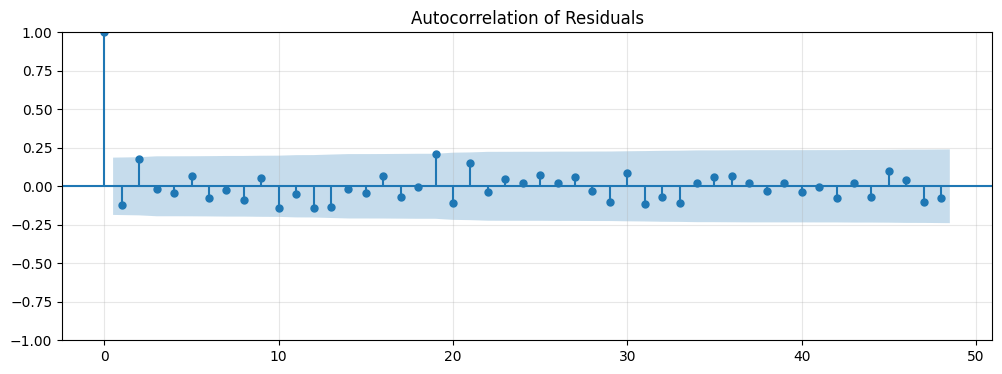

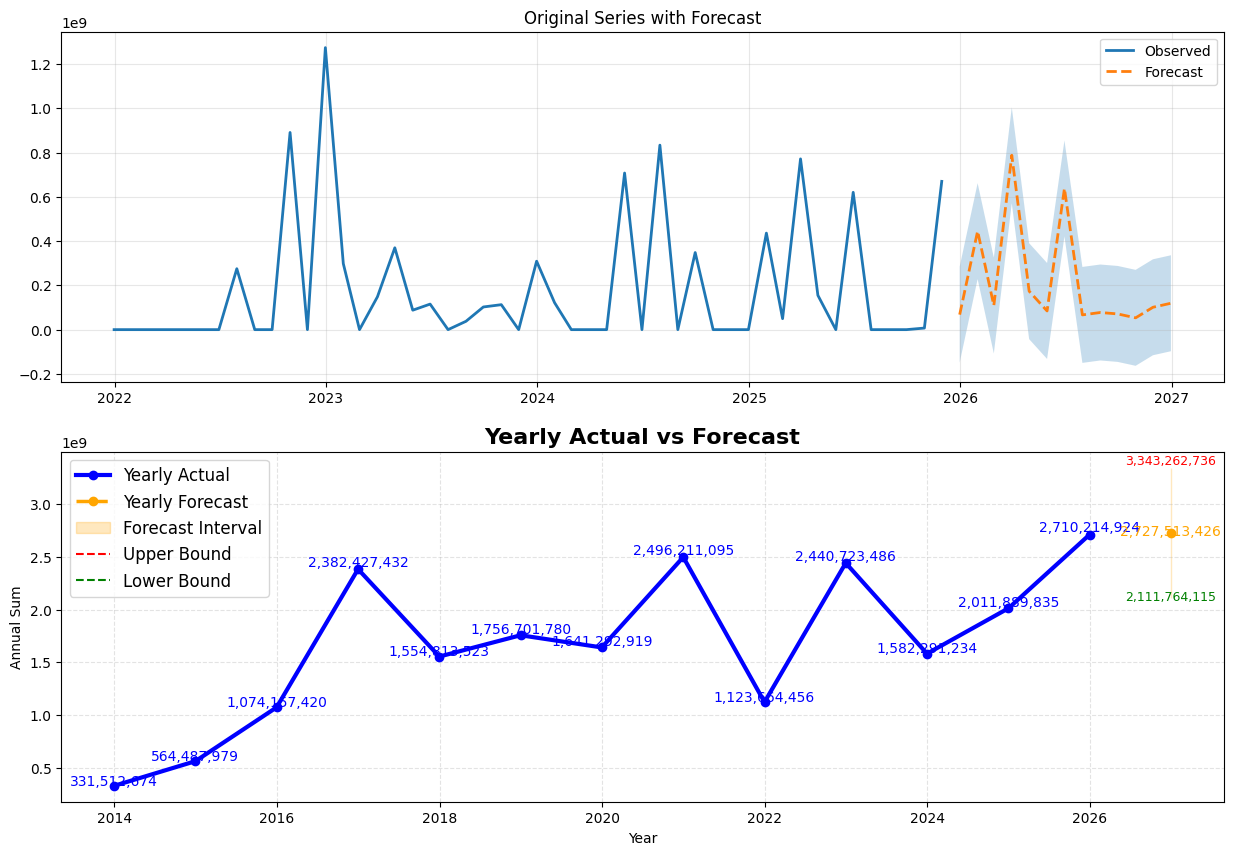

In [36]:
def deal_with_resid_graphs(lag_choice):
    flag = 1
    fig, ax = plt.subplots(figsize=(12, 4))
    while flag:
        if resid_comp.dropna().count() > lag_choice:
            plot_acf(resid_comp.dropna(), lags=lag_choice, ax=ax)
            flag = 0
        else:
            lag_choice = lag_choice - 1
        

    ax.set_title('Autocorrelation of Residuals')
    ax.grid(alpha=0.3)
    plt.show()

    fig, ax = plt.subplots(2, 1, figsize=(15, 10))

    ax[0].plot(ts_original[-N:], label='Observed', linewidth=2)
    ax[0].plot(forecast_monthly[-N:], '--', label='Forecast', linewidth=2)

    ax[0].fill_between(
        lower_bound_monthly[-N:].index,
        lower_bound_monthly[-N:].values,
        upper_bound_monthly[-N:].values,
        alpha=0.25
    )

    ax[0].set_title('Original Series with Forecast')
    ax[0].legend()
    ax[0].grid(alpha=0.3)


    # Plot yearly actual and forecast
    ax[1].plot(yearly_actual, marker='o', linewidth=3, color='blue', label='Yearly Actual')
    ax[1].plot(forecast_yearly, '--o', linewidth=2.5, color='orange', label='Yearly Forecast')

    # Shaded confidence interval
    ax[1].fill_between(
        forecast_yearly.index,
        lower_bound_yearly.values,
        upper_bound_yearly.values,
        color='orange',
        alpha=0.25,
        label='Forecast Interval'
    )

    # Plot upper and lower bounds as thin lines
    ax[1].plot(upper_bound_yearly, '--', color='red', linewidth=1.5, label='Upper Bound')
    ax[1].plot(lower_bound_yearly, '--', color='green', linewidth=1.5, label='Lower Bound')

    # Titles, labels, grid
    ax[1].set_title('Yearly Actual vs Forecast', fontsize=16, weight='bold')
    ax[1].set_ylabel('Annual Sum')
    ax[1].set_xlabel('Year')
    ax[1].legend(frameon=True, fontsize=12)
    ax[1].grid(alpha=0.35, linestyle='--')

    # Annotate values (optional)
    for x, y in zip(yearly_actual.index, yearly_actual.values):
        ax[1].text(x, y*1.01, f'{y:,.0f}', ha='center', fontsize=10, color='blue')

    for x, y in zip(forecast_yearly.index, forecast_yearly.values):
        ax[1].text(x, y*0.99, f'{y:,.0f}', ha='center', fontsize=10, color='orange')

    for x, y in zip(upper_bound_yearly.index, upper_bound_yearly.values):
        ax[1].text(x, y*1.01, f'{y:,.0f}', ha='center', fontsize=9, color='red')

    for x, y in zip(lower_bound_yearly.index, lower_bound_yearly.values):
        ax[1].text(x, y*0.99, f'{y:,.0f}', ha='center', fontsize=9, color='green')

lag_choice = 48
resid_independent = False
lb = acorr_ljungbox(resid_comp.dropna(), lags=[12, 24], return_df=True)
if (lb["lb_pvalue"].iloc[0] > 0.05) or (lb["lb_pvalue"].iloc[1] > 0.05):
    display(Markdown("## Residuals are independently distributed (fail to reject H0 in Ljung-Box test) aka white noise"))
else:
    display(Markdown("## Residuals are not independently distributed (reject H0) aka not white noise"))
if resid_comp.dropna().count() < 11:
    print("resid serve no value")
else:
    deal_with_resid_graphs(lag_choice)

In [37]:
def forecast_all_ts(data_clean):

    forecast_rows = []
    bad_ts_rows = []

    unique_combos = (
        data_clean
        .groupby(["huka", "expediture_type", fc_or_zroa_selected, "doc_type"])
        ["mimun"]
        .sum()
        .index
    )

    for combo in unique_combos:
        huka, exp_type, fc_val, doc_type = combo

        mask_clean = (
            (data_clean["huka"] == huka) &
            (data_clean["expediture_type"] == exp_type) &
            (data_clean[fc_or_zroa_selected] == fc_val) &
            (data_clean["doc_type"] == doc_type)
        )
        time_series = data_clean.loc[mask_clean].groupby("paymant_date")["mimun"].sum().resample("ME").sum().fillna(0)

        inspector = TimeSeriesInspector(time_series)
        clean_active_ts = inspector.get_clean_active_ts()
        clean_active_ts = fill_inactive_months(clean_active_ts)

        # -----------------------------
        # BAD TS
        # -----------------------------
        if clean_active_ts[clean_active_ts>0].count() < 12:
            bad_ts_rows.append({
                "huka": huka,
                "expediture_type": exp_type,
                fc_or_zroa_selected: fc_val,
                "doc_type": doc_type,
            })
        else:

            # -----------------------------
            # TREND + DIAGNOSTICS
            # -----------------------------
            trend, rolling_std = find_trend_and_rolling_std(clean_active_ts)
            slope, r2, elasticity, model_prediction = variance_trend_diagnostics(
                trend, rolling_std
            )

            decomposition_type, reason_of_decomposition = choose_decomposition(
                clean_active_ts, r2, elasticity
            )

            # FORCE ADDITIVE (your request)
            decomposition_type = "additive"

            decomposition = make_decompose(clean_active_ts, decomposition_type)
            trend_comp, seasonal_comp, resid_comp = extract_decomposition(decomposition)

            # -----------------------------
            # FORECAST HORIZON
            # -----------------------------
            last_date = trend_comp.index[-1]
            months_to_predict = (
                (YEAR_TO_PREDICT + 1 - last_date.year) * MONTHS_IN_YEAR
                - last_date.month
            )

            # -----------------------------
            # TREND FORECAST
            # -----------------------------
            model = ARIMA(trend_comp, order=ARIMA_ORDER)
            results = model.fit()
            trend_forecast = results.forecast(steps=months_to_predict)

            # -----------------------------
            # SEASONAL FORECAST
            # -----------------------------
            last_season = seasonal_comp.iloc[-12:].values

            seasonal_forecast_values = np.tile(
                last_season,
                reps=(months_to_predict // MONTHS_IN_YEAR + 1)
            )[:months_to_predict]

            seasonal_forecast_index = pd.date_range(
                start=trend_forecast.index[0],
                periods=months_to_predict,
                freq="ME"
            )

            seasonal_forecast = pd.Series(
                seasonal_forecast_values,
                index=seasonal_forecast_index
            )
        
            # -----------------------------
            # MONTHLY FORECAST (ADDITIVE)
            # -----------------------------
            forecast_monthly = trend_forecast + seasonal_forecast

            forecast_monthly = forecast_monthly[
                forecast_monthly.index.year == YEAR_TO_PREDICT
            ]

            # -----------------------------
            # STORE WIDE ROW
            # -----------------------------
            row = {
                "huka": huka,
                "expediture_type": exp_type,
                fc_or_zroa_selected: fc_val,
                "doc_type": doc_type,
            }

            for dt, val in forecast_monthly.items():
                row[dt.strftime("%Y-%m")] = val

            forecast_rows.append(row)

    # -----------------------------
    # BUILD FINAL DATAFRAMES
    # -----------------------------
    forecast_ts = (
        pd.DataFrame(forecast_rows)
        .set_index(["huka", "expediture_type", fc_or_zroa_selected, "doc_type"])
        .sort_index()
    )

    bad_ts = (
        pd.DataFrame(bad_ts_rows)
        .set_index(["huka", "expediture_type", fc_or_zroa_selected, "doc_type"])
        .sort_index()
    )
    # add to bad rows forcasted month that will be mean of of the series in years = [2023, 2024, 2025]
    for idx, row in bad_ts.iterrows():
        huka = idx[0]
        exp_type = idx[1]
        fc_val = idx[2]
        doc_type = idx[3]

        mask_original = (
            (data_clean["huka"] == huka) &
            (data_clean["expediture_type"] == exp_type) &
            (data_clean[fc_or_zroa_selected] == fc_val) &
            (data_clean["doc_type"] == doc_type)
        )
        time_series_original = data_clean.loc[mask_original].groupby("paymant_date")["mimun"].sum().resample("ME").sum().fillna(0)

        mean_value = time_series_original[
            (time_series_original.index.year >= YEAR_TO_PREDICT - 2) &
            (time_series_original.index.year <= YEAR_TO_PREDICT)
        ].mean()

        for month in range(1, 13):
            month_str = f"{YEAR_TO_PREDICT}-{month:02d}"
            bad_ts.at[idx, month_str] = mean_value

    return forecast_ts, bad_ts.fillna(0)


original_data_daily = (
    tashlomim_data_specific_coin
    .groupby(FULL_KEYS, as_index=False)
    .agg(mimun=('mimun', 'sum'))
    .sort_values('paymant_date')
)

spike_detector = SpikeDetection(original_data_daily.copy())
all_data_daily, flagged_as_spikes, data_clean = spike_detector.find_spikes()

data_clean = data_clean[ FULL_KEYS + ['mimun'] ]

forecasted_df, bad_ts = forecast_all_ts(data_clean)

# add bad ts to forecasted df
all_forecasted_df = pd.concat([forecasted_df, bad_ts], axis=0)
forecasted_df["forcast_yearly"] = all_forecasted_df.apply(
    lambda row: row.filter(like=f"{YEAR_TO_PREDICT}-").sum(),
    axis=1
)

In [38]:
# sum in total forecasted value
total_forecasted_value = forecasted_df["forcast_yearly"].sum()
# sum of bad ts in TODAY_YEAR
data_for_bad_ts = tashlomim_data_specific_coin[
    (tashlomim_data_specific_coin['paymant_date'].dt.year == TODAY_YEAR) & 
    (tashlomim_data_specific_coin['huka'].isin(bad_ts.index.get_level_values('huka'))) &
    (tashlomim_data_specific_coin['expediture_type'].isin(bad_ts.index.get_level_values('expediture_type'))) &
    (tashlomim_data_specific_coin[fc_or_zroa_selected].isin(bad_ts.index.get_level_values(fc_or_zroa_selected))) &
    (tashlomim_data_specific_coin['doc_type'].isin(bad_ts.index.get_level_values('doc_type')))
].groupby(KEYS, as_index=False).agg(mimun=('mimun', 'sum'))
total_bad_ts_value = data_for_bad_ts['mimun'].sum()
just_yearly_forcast = forecasted_df[["forcast_yearly"]]

# to csv
forecasted_df.to_csv(f"forecasted_ts_{COIN_TO_INSPECT}.csv")
bad_ts.to_csv(f"bad_ts_{COIN_TO_INSPECT}.csv")
# add actual 2025 values to just_yearly_forcast
# years to add
years = [2023, 2024, 2025]

for year in years:
    values_for_year = (
        tashlomim_data_specific_coin[
            tashlomim_data_specific_coin['paymant_date'].dt.year == year
        ]
        .groupby(KEYS, as_index=False)
        .agg(mimun=('mimun', 'sum'))
        .set_index(['huka', 'expediture_type', fc_or_zroa_selected, 'doc_type'])
        .rename(columns={'mimun': f'actual_{year}'})
    )

    just_yearly_forcast = just_yearly_forcast.merge(
        values_for_year[[f'actual_{year}']],
        left_index=True,
        right_index=True,
        how='left'
    )
just_yearly_forcast = just_yearly_forcast.fillna(0)
just_yearly_forcast = just_yearly_forcast[~((just_yearly_forcast["actual_2023"] == 0) & (just_yearly_forcast["actual_2024"] == 0) & (just_yearly_forcast["actual_2025"] == 0))]
display(Markdown(f"## Total forecasted value for year {YEAR_TO_PREDICT}: {just_yearly_forcast['forcast_yearly'].sum():,.2f}"))

# save result
just_yearly_forcast.to_csv(f"yearly_forecast_vs_actual_{COIN_TO_INSPECT}.csv")


## Total forecasted value for year 2026: 4,719,017,860.54

In [ ]:

bad_ts_to_plot = bad_ts.index[1]
tashlomim_data_specific_coin_filtered = tashlomim_data_specific_coin[
    (tashlomim_data_specific_coin['huka'] == bad_ts_to_plot[0]) &
    (tashlomim_data_specific_coin['expediture_type'] == bad_ts_to_plot[1]) &
    (tashlomim_data_specific_coin[fc_or_zroa_selected] == bad_ts_to_plot[2]) &
    (tashlomim_data_specific_coin['doc_type'] == bad_ts_to_plot[3])
]
bad_ts_time_series = tashlomim_data_specific_coin_filtered.groupby(
    pd.Grouper(key="paymant_date", freq="ME")
)["mimun"].sum().fillna(0)
bad_ts_time_series.plot(
    title=f"Bad TS Example: huka={bad_ts_to_plot[0]}, exp={bad_ts_to_plot[1]}, {fc_or_zroa_selected}={bad_ts_to_plot[2]}, doc={bad_ts_to_plot[3]}",
    figsize=(12,6)
)


'\nbad_ts_to_plot = bad_ts.index[1]\ntashlomim_data_specific_coin_filtered = tashlomim_data_specific_coin[\n    (tashlomim_data_specific_coin[\'huka\'] == bad_ts_to_plot[0]) &\n    (tashlomim_data_specific_coin[\'expediture_type\'] == bad_ts_to_plot[1]) &\n    (tashlomim_data_specific_coin[fc_or_zroa_selected] == bad_ts_to_plot[2]) &\n    (tashlomim_data_specific_coin[\'doc_type\'] == bad_ts_to_plot[3])\n]\nbad_ts_time_series = tashlomim_data_specific_coin_filtered.groupby(\n    pd.Grouper(key="paymant_date", freq="ME")\n)["mimun"].sum().fillna(0)\nbad_ts_time_series.plot(\n    title=f"Bad TS Example: huka={bad_ts_to_plot[0]}, exp={bad_ts_to_plot[1]}, {fc_or_zroa_selected}={bad_ts_to_plot[2]}, doc={bad_ts_to_plot[3]}",\n    figsize=(12,6)\n)\n'